# Actigraphy Preprocessing

## Week Data

In [10]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.dates import WeekdayLocator
import plotly.express as px
import seaborn as sns

from wearables import preproc
from hampel import hampel

In [2]:
actig_files = sorted(glob.glob('/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/raw/*.csv'))

# actig_files_ = random.sample(actig_files, 10)

actig_files[:5]

['/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/raw/30004_10_23_2017_10_20_00_AM_New_Analysis.csv',
 '/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/raw/30008_11_9_2017_11_38_00_AM_New_Analysis.csv',
 '/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/raw/30009_10_27_2017_6_35_00_PM_New_Analysis.csv',
 '/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/raw/30012_10_30_2017_6_24_00_PM_New_Analysis.csv',
 '/Users/mcmahonmc/Box/CogNeuroLab/Aging Decision Making R01/data/actigraphy/raw/30015_11_10_2017_4_15_00_PM_New_Analysis.csv']

## Cyclic week

successfully read Actiware data file
record 40694
40694 missing 0 values out of 34676 total (0.00 percent)
interpolated - now missing 0 values out of 34676 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_11152/1724524193.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


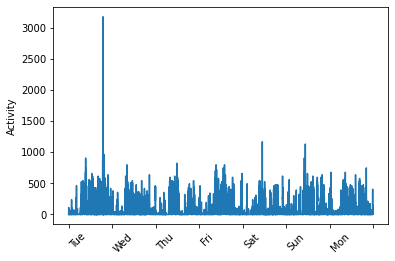

(169,)
(169, 1)


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_11152/1724524193.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


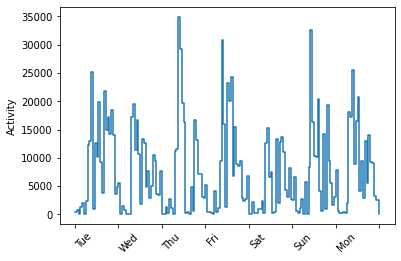

In [16]:
import scipy.stats as stats
from scipy.interpolate import interp1d

actdf = pd.DataFrame()

weekday_map= {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu',
              4:'Fri', 5:'Sat', 6:'Sun'}

for file in actig_files:
    
    subject = file.split('raw/')[1][:5]
#     print(subject)
    
    # read in actigraphy data
    act = preproc.preproc(file, 'actiwatch', sr='.5T', truncate=False, write=False, plot=True, recording_period_min=7)
    
    # find first Monday midnight and start data from there so all subjects starting on same day of the week
    start = act[(act.index.dayofweek == 1) & (act.index.hour == 0)].index[0]
    
    # cyclically wrap days that were cut off so not losing data
    wrap = act[:start]
    wrap.index = pd.date_range(start=act[start:].last_valid_index() + pd.Timedelta(seconds=30),
                                  end=act[start:].last_valid_index() + (wrap.last_valid_index() - wrap.first_valid_index()) + pd.Timedelta(seconds=30),
                                  freq='30S')
    
    act = pd.concat((act[start:], wrap))
    
    # keep only seven days of data
    act = act[act.index <= (act.index[2] + pd.Timedelta(days=7))]
    
    # interpolate outliers
    act0 = act.copy()
    act = hampel(act, window_size=5, n=1, imputation=True)
    
    x_dates = [ weekday_map[day] for day in act.index.dayofweek.unique() ]
    
    # plot
    fig, ax = plt.subplots()
    fig = sns.lineplot(x=act.index, y=act)#.set(title='sub-%s' % subject)
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')
    ax.set_xlabel(''); ax.set_ylabel('Activity')
    
    plt.savefig('/Users/mcmahonmc/Github/machine-learning-2021/final_project/results/actigraphy_ex.png', dpi=300, bbox_inches='tight', facecolor='w')
    plt.show()
    plt.close()
    # if subject has < 7 days data, discard, else add to dataset
    if ( (act.last_valid_index() - act.first_valid_index()) >= pd.Timedelta(days=7) ):
    
        act = act.resample('60min').sum()
        print(act.shape)
        actdf[subject] = act.values
        print(actdf.shape)
        
        fig, ax = plt.subplots()
        fig = sns.lineplot(x=act.index, y=act, drawstyle='steps-post')#.set(title='sub-%s' % subject)
        ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')
        ax.set_xlabel(''); ax.set_ylabel('Activity')

        plt.savefig('/Users/mcmahonmc/Github/machine-learning-2021/final_project/results/actigraphy_ex_hourly.png', dpi=300, bbox_inches='tight', facecolor='w')
        plt.show()
        plt.close()

    else:
        
        print('sub-%s discarded, recording period %s days' % 
              (subject, act.last_valid_index() - act.first_valid_index()))
    
    


In [9]:
actdf.to_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/data/actigraphy_data_week-hourly_df.csv', index=False)

## 24 hr day

successfully read Actiware data file
record 30004
30004 missing 0 values out of 29404 total (0.00 percent)
interpolated - now missing 0 values out of 29404 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


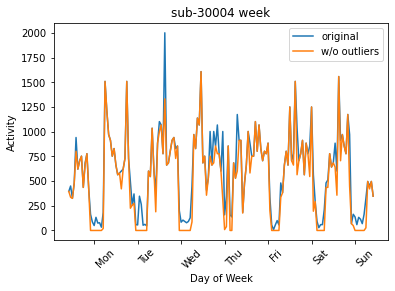

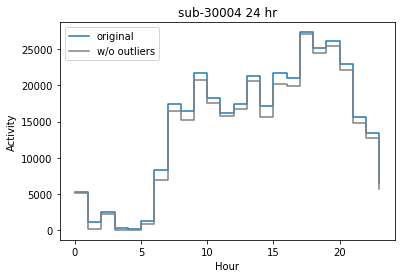

(24, 1)
successfully read Actiware data file
record 30008
30008 missing 0 values out of 31919 total (0.00 percent)
interpolated - now missing 0 values out of 31919 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


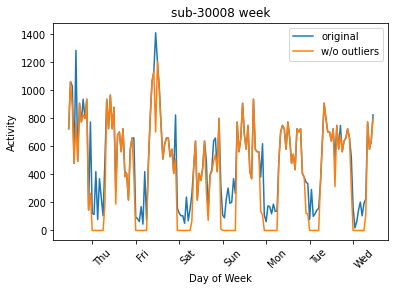

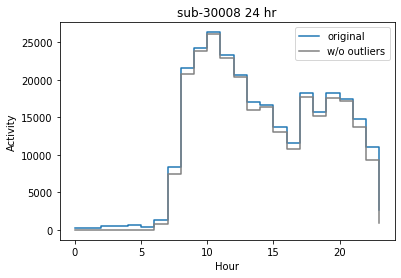

(24, 2)
successfully read Actiware data file
record 30009
30009 missing 0 values out of 29134 total (0.00 percent)
interpolated - now missing 0 values out of 29134 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


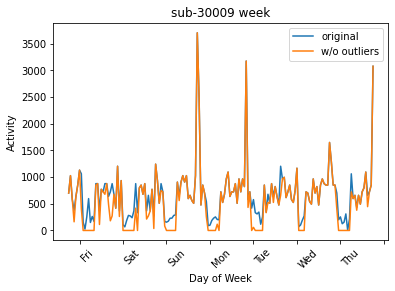

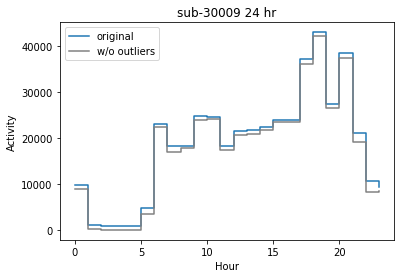

(24, 3)
successfully read Actiware data file
record 30012
30012 missing 0 values out of 28788 total (0.00 percent)
interpolated - now missing 0 values out of 28788 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


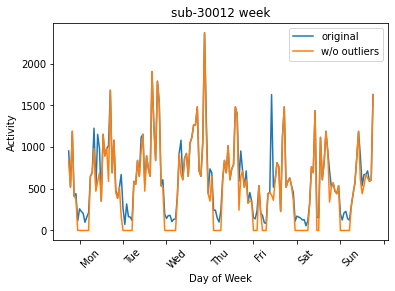

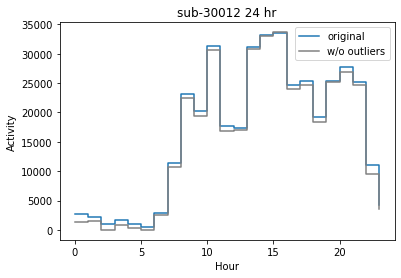

(24, 4)
successfully read Actiware data file
record 30015
30015 missing 0 values out of 31899 total (0.00 percent)
interpolated - now missing 0 values out of 31899 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


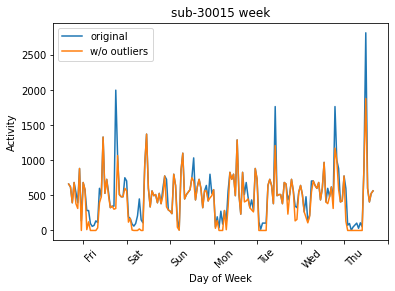

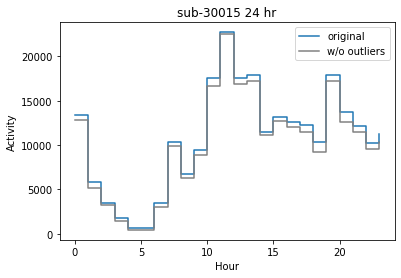

(24, 5)
successfully read Actiware data file
record 30015
30015 missing 0 values out of 34422 total (0.00 percent)
interpolated - now missing 0 values out of 34422 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


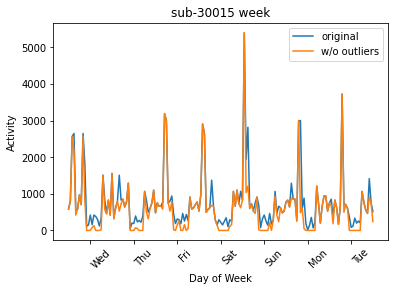

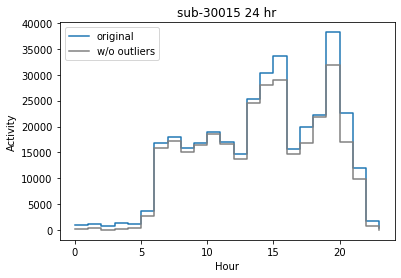

(24, 5)
successfully read Actiware data file
record 30019
30019 missing 0 values out of 32118 total (0.00 percent)
interpolated - now missing 0 values out of 32118 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


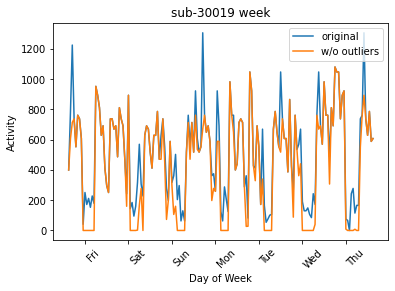

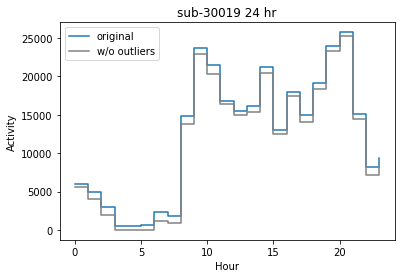

(24, 6)
successfully read Actiware data file
record 30020
30020 missing 0 values out of 28913 total (0.00 percent)
interpolated - now missing 0 values out of 28913 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


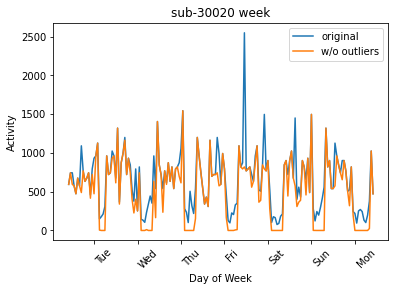

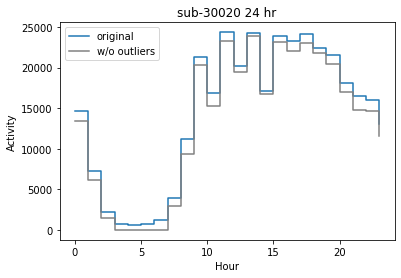

(24, 7)
successfully read Actiware data file
record 30023
30023 missing 0 values out of 28874 total (0.00 percent)
interpolated - now missing 0 values out of 28874 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


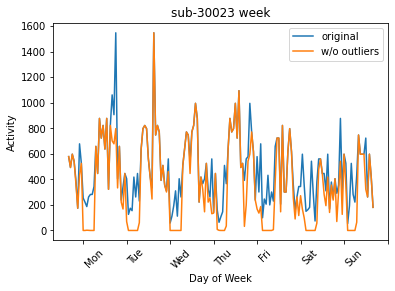

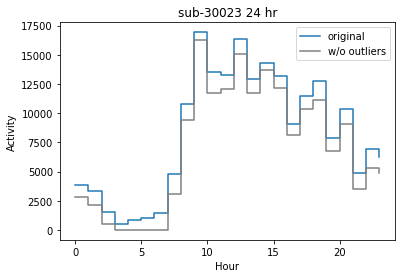

(24, 8)
successfully read Actiware data file
record 30027
30027 missing 0 values out of 34716 total (0.00 percent)
interpolated - now missing 0 values out of 34716 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


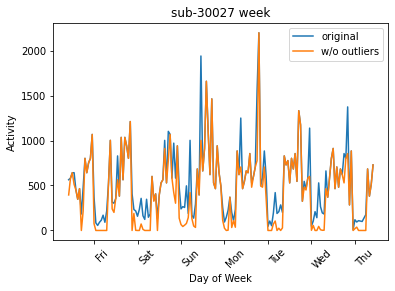

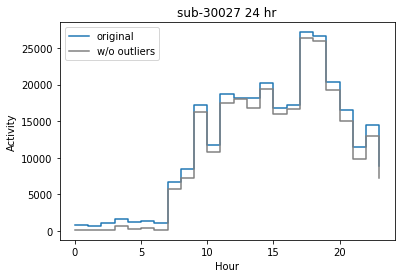

(24, 9)
successfully read Actiware data file
record 30040
30040 missing 0 values out of 29813 total (0.00 percent)
interpolated - now missing 0 values out of 29813 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


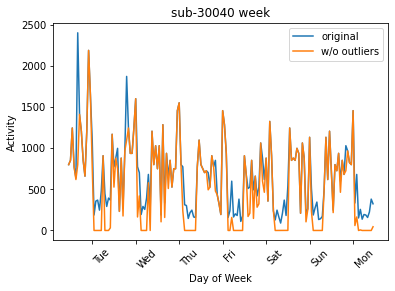

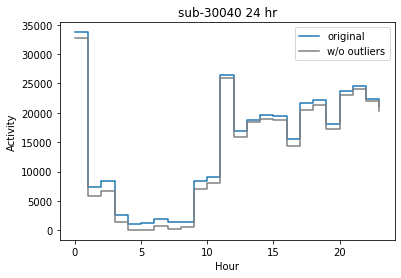

(24, 10)
successfully read Actiware data file
record 30057
30057 missing 0 values out of 29359 total (0.00 percent)
interpolated - now missing 0 values out of 29359 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


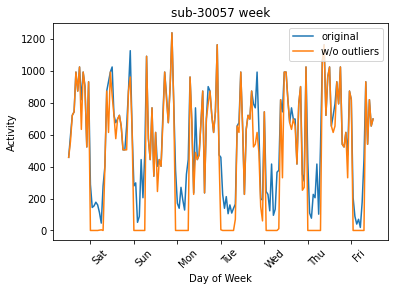

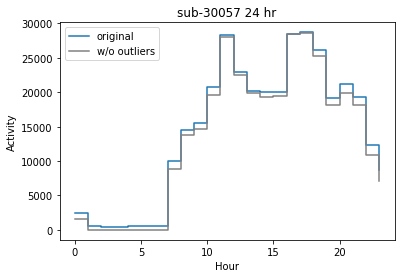

(24, 11)
successfully read Actiware data file
record 30064
30064 missing 0 values out of 31880 total (0.00 percent)
interpolated - now missing 0 values out of 31880 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


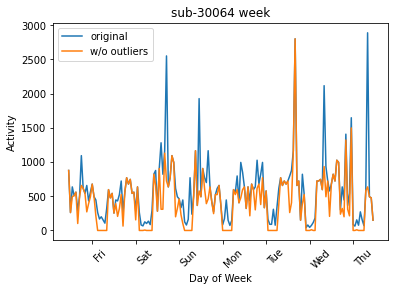

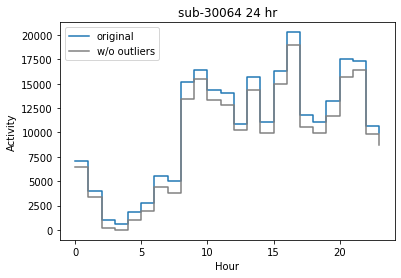

(24, 12)
successfully read Actiware data file
record 30066
30066 missing 0 values out of 28615 total (0.00 percent)
interpolated - now missing 0 values out of 28615 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


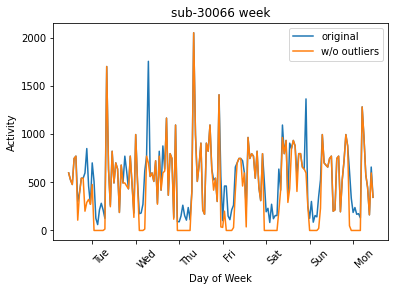

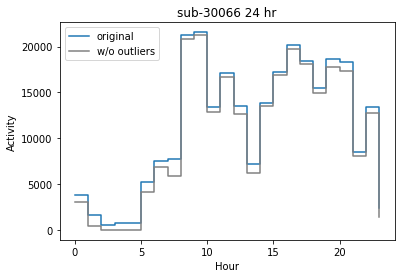

(24, 13)
successfully read Actiware data file
record 30069
30069 missing 0 values out of 34292 total (0.00 percent)
interpolated - now missing 0 values out of 34292 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


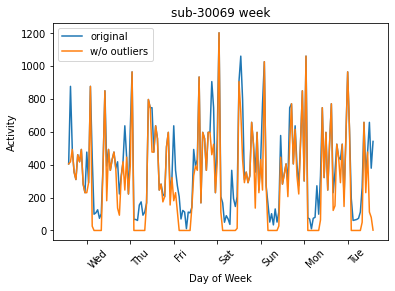

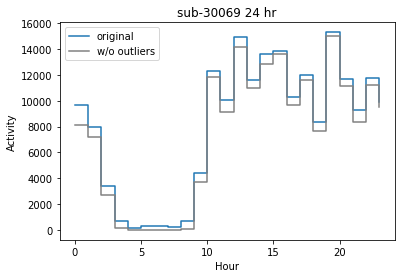

(24, 14)
successfully read Actiware data file
record 30074
30074 missing 0 values out of 40250 total (0.00 percent)
interpolated - now missing 0 values out of 40250 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


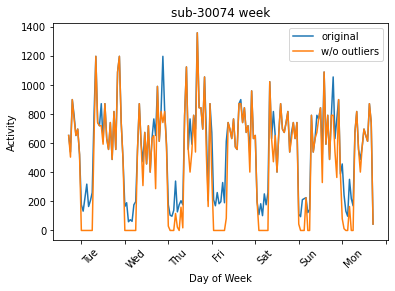

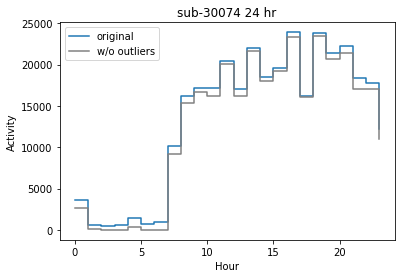

(24, 15)
successfully read Actiware data file
record 30085
30085 missing 0 values out of 28779 total (0.00 percent)
interpolated - now missing 0 values out of 28779 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


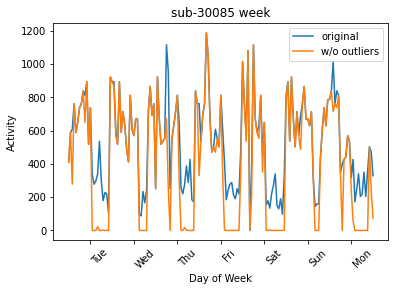

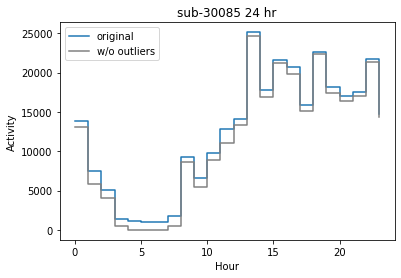

(24, 16)
successfully read Actiware data file
record 30088
30088 missing 0 values out of 40314 total (0.00 percent)
interpolated - now missing 0 values out of 40314 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


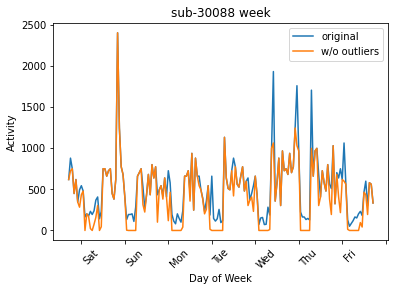

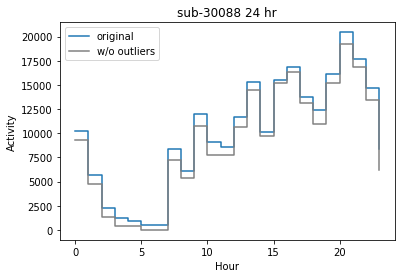

(24, 17)
successfully read Actiware data file
record 30090
30090 missing 0 values out of 29517 total (0.00 percent)
interpolated - now missing 0 values out of 29517 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


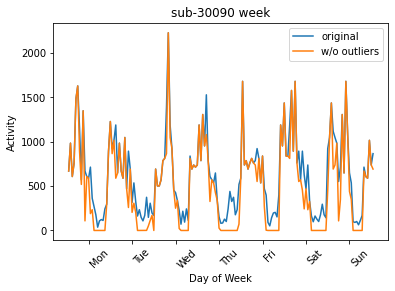

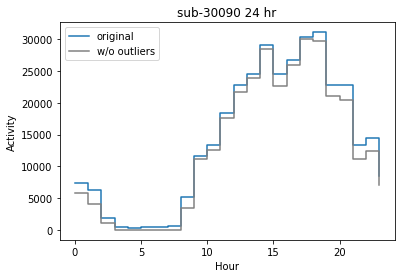

(24, 18)
successfully read Actiware data file
record 30091
30091 missing 0 values out of 39897 total (0.00 percent)
interpolated - now missing 0 values out of 39897 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


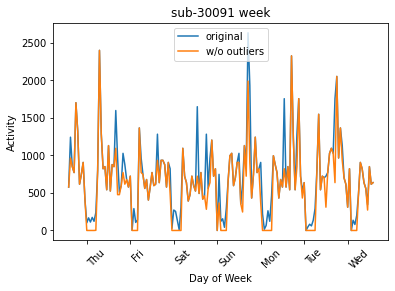

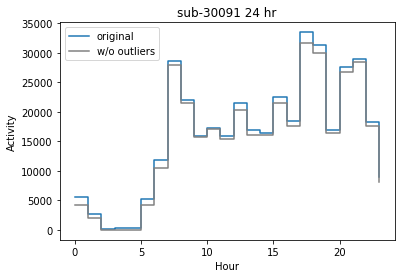

(24, 19)
successfully read Actiware data file
record 30091
30091 missing 0 values out of 34504 total (0.00 percent)
interpolated - now missing 0 values out of 34504 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


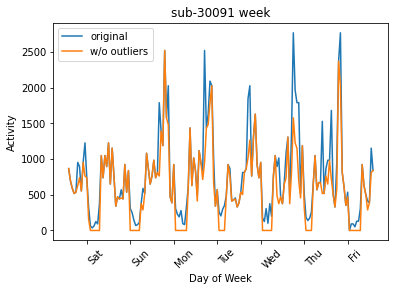

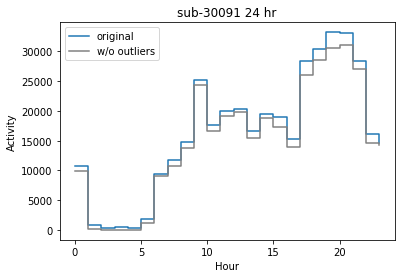

(24, 19)
successfully read Actiware data file
record 30095
30095 missing 0 values out of 40298 total (0.00 percent)
interpolated - now missing 0 values out of 40298 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


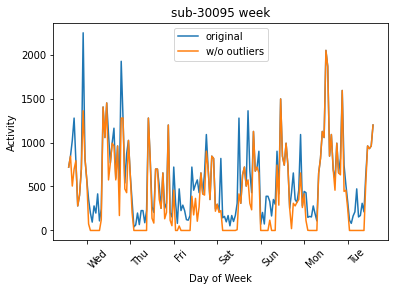

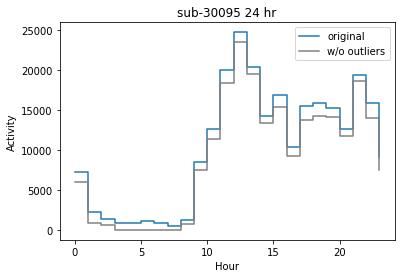

(24, 20)
successfully read Actiware data file
record 30096
30096 missing 0 values out of 31775 total (0.00 percent)
interpolated - now missing 0 values out of 31775 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


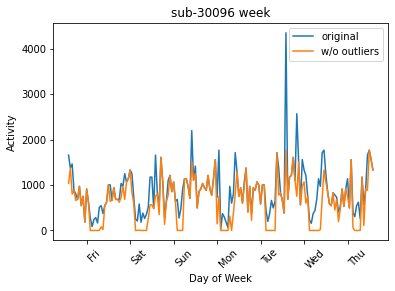

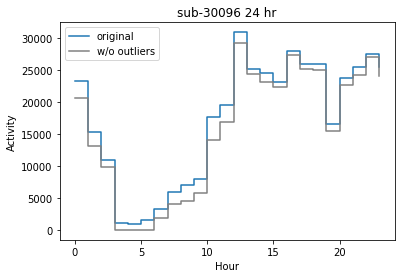

(24, 21)
successfully read Actiware data file
record 30101
30101 missing 0 values out of 28105 total (0.00 percent)
interpolated - now missing 0 values out of 28105 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


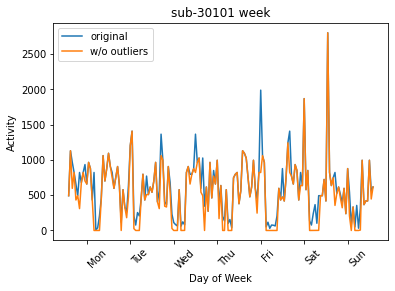

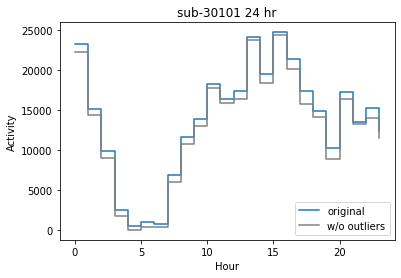

(24, 22)
successfully read Actiware data file
record 30116
30116 missing 0 values out of 32569 total (0.00 percent)
interpolated - now missing 0 values out of 32569 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


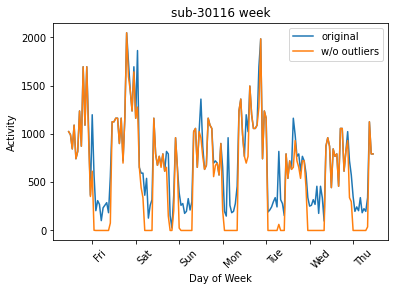

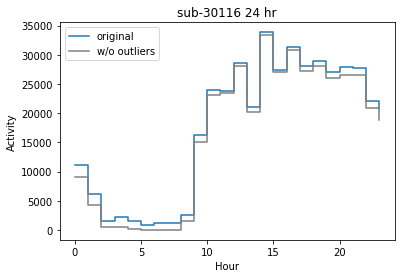

(24, 23)
successfully read Actiware data file
record 30118
30118 missing 0 values out of 28530 total (0.00 percent)
interpolated - now missing 0 values out of 28530 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


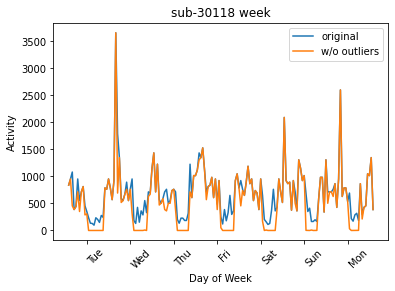

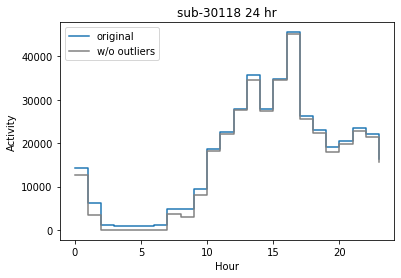

(24, 24)
successfully read Actiware data file
record 30119
30119 missing 0 values out of 34829 total (0.00 percent)
interpolated - now missing 0 values out of 34829 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


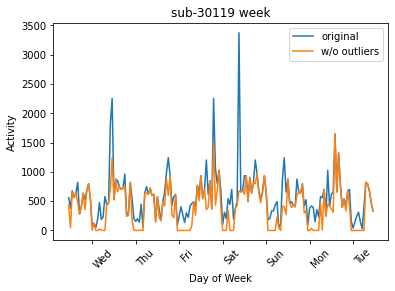

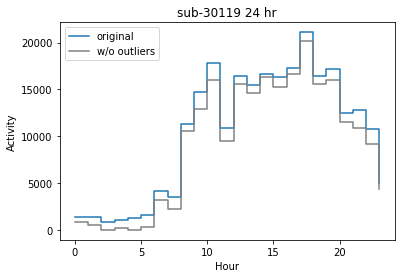

(24, 25)
successfully read Actiware data file
record 30119
30119 missing 0 values out of 35158 total (0.00 percent)
interpolated - now missing 0 values out of 35158 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


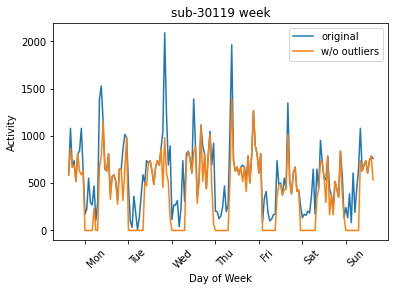

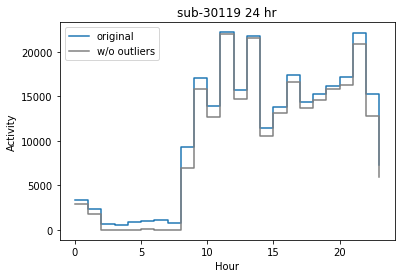

(24, 25)
successfully read Actiware data file
record 30128
30128 missing 0 values out of 28788 total (0.00 percent)
interpolated - now missing 0 values out of 28788 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


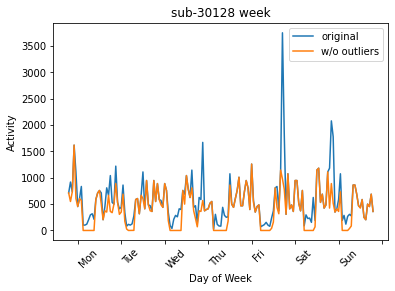

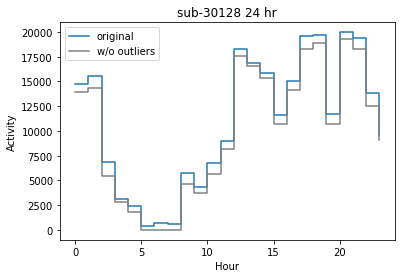

(24, 26)
successfully read Actiware data file
record 30181
30181 missing 0 values out of 29933 total (0.00 percent)
interpolated - now missing 0 values out of 29933 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


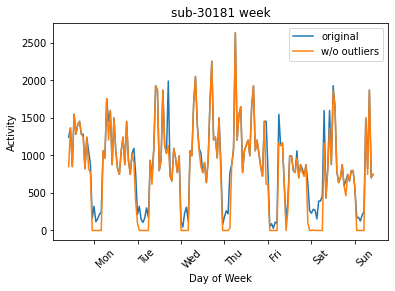

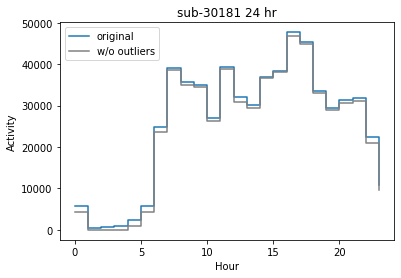

(24, 27)
successfully read Actiware data file
record 30217
30217 missing 0 values out of 37960 total (0.00 percent)
interpolated - now missing 0 values out of 37960 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


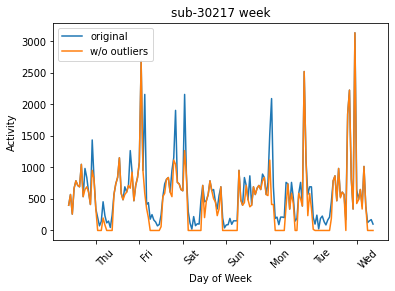

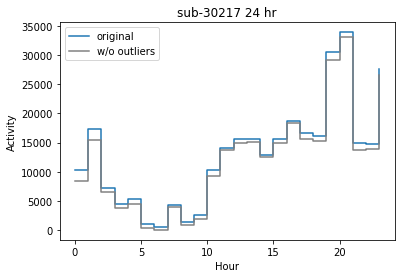

(24, 28)
successfully read Actiware data file
record 30227
30227 missing 0 values out of 34368 total (0.00 percent)
interpolated - now missing 0 values out of 34368 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


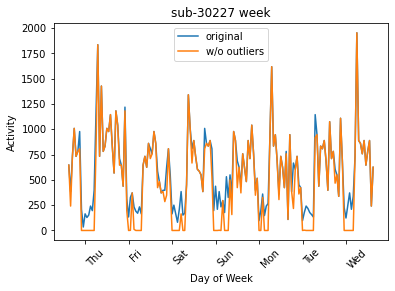

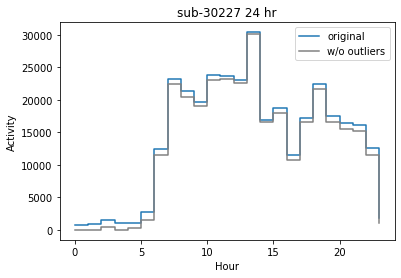

(24, 29)
successfully read Actiware data file
record 30236
30236 missing 0 values out of 35048 total (0.00 percent)
interpolated - now missing 0 values out of 35048 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


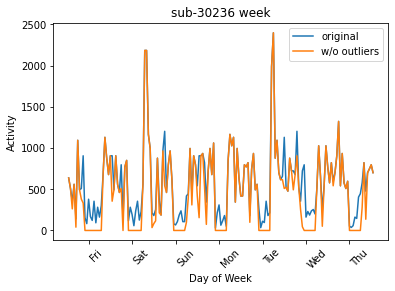

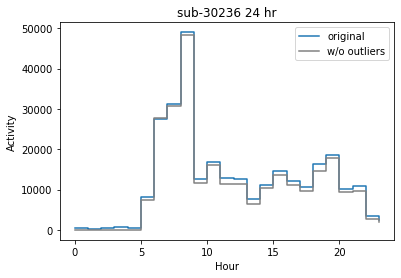

(24, 30)
successfully read Actiware data file
record 30242
30242 missing 0 values out of 31757 total (0.00 percent)
interpolated - now missing 0 values out of 31757 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


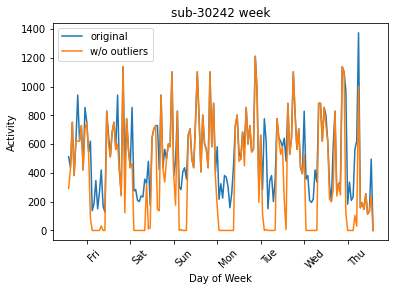

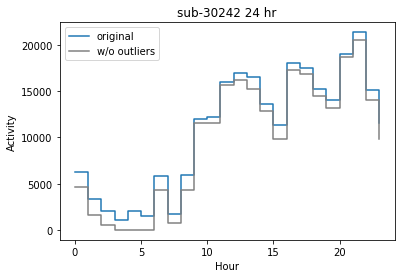

(24, 31)
successfully read Actiware data file
record 30242
30242 missing 0 values out of 37316 total (0.00 percent)
interpolated - now missing 0 values out of 37316 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


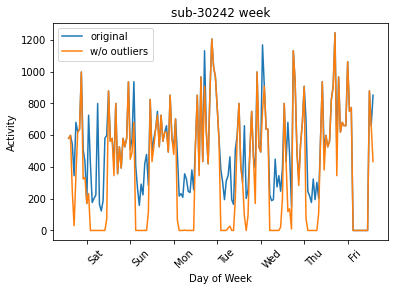

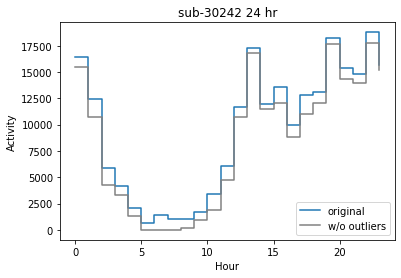

(24, 31)
successfully read Actiware data file
record 30255
30255 missing 0 values out of 28951 total (0.00 percent)
interpolated - now missing 0 values out of 28951 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


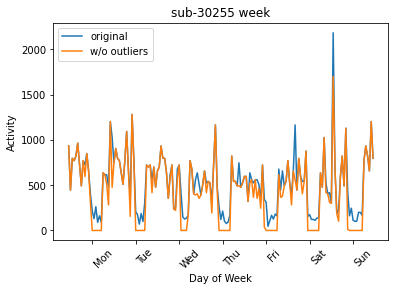

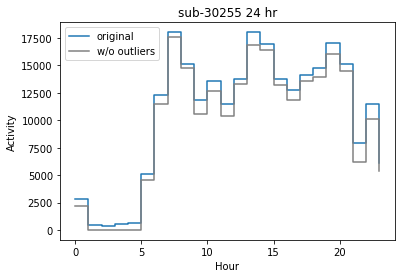

(24, 32)
successfully read Actiware data file
record 30274
30274 missing 0 values out of 31471 total (0.00 percent)
interpolated - now missing 0 values out of 31471 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


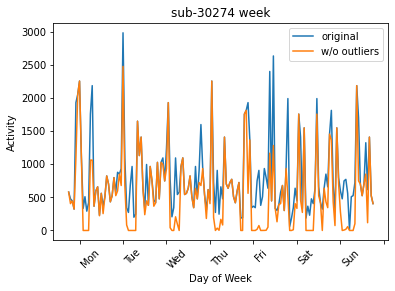

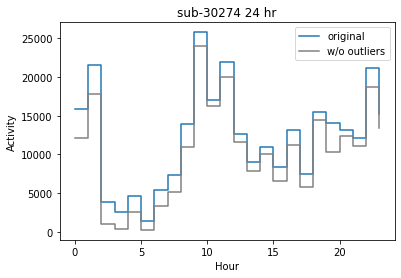

(24, 33)
successfully read Actiware data file
record 30283
30283 missing 0 values out of 31814 total (0.00 percent)
interpolated - now missing 0 values out of 31814 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


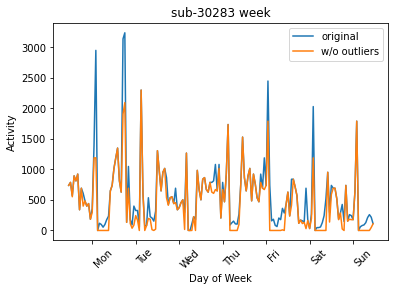

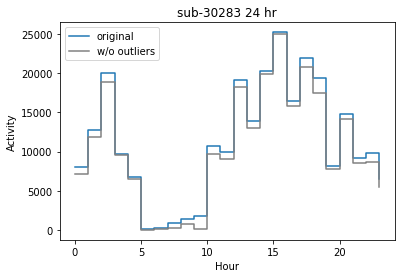

(24, 34)
successfully read Actiware data file
record 30295
30295 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


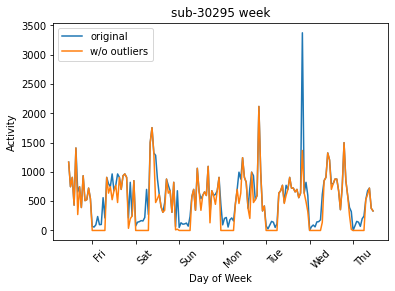

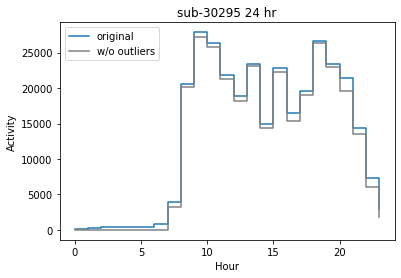

(24, 35)
successfully read Actiware data file
record 30330
30330 missing 0 values out of 31950 total (0.00 percent)
interpolated - now missing 0 values out of 31950 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


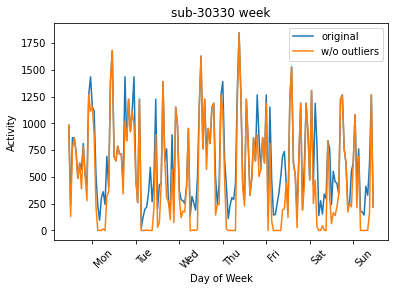

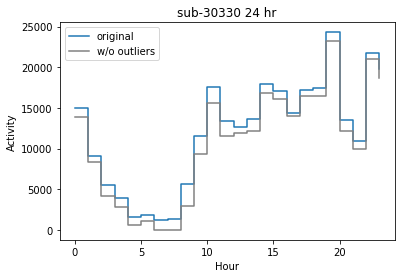

(24, 36)
successfully read Actiware data file
record 30346
30346 missing 0 values out of 40133 total (0.00 percent)
interpolated - now missing 0 values out of 40133 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


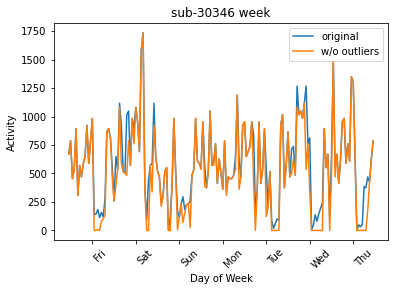

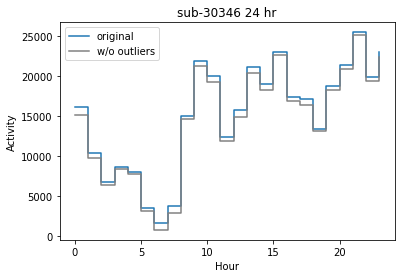

(24, 37)
successfully read Actiware data file
record 30376
30376 missing 0 values out of 40216 total (0.00 percent)
interpolated - now missing 0 values out of 40216 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


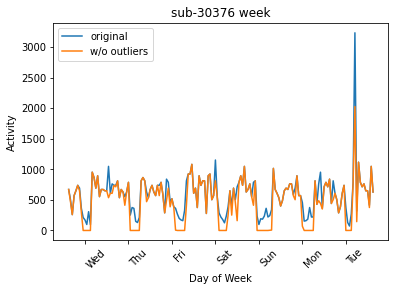

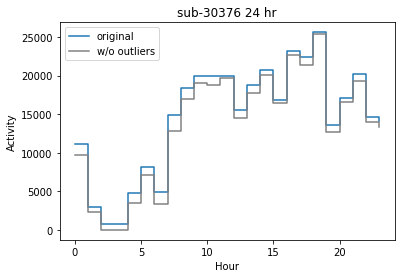

(24, 38)
successfully read Actiware data file
record 30395
30395 missing 0 values out of 32249 total (0.00 percent)
interpolated - now missing 0 values out of 32249 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


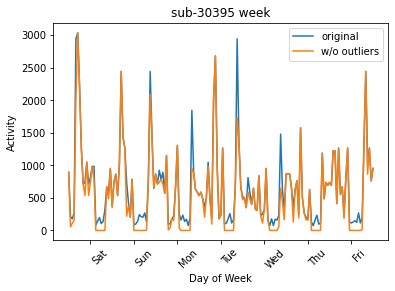

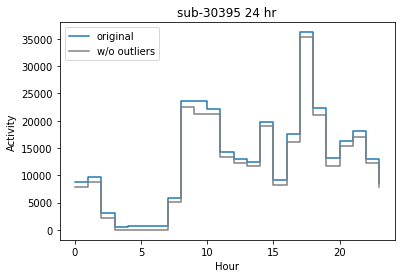

(24, 39)
successfully read Actiware data file
record 30400
30400 missing 0 values out of 40251 total (0.00 percent)
interpolated - now missing 0 values out of 40251 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


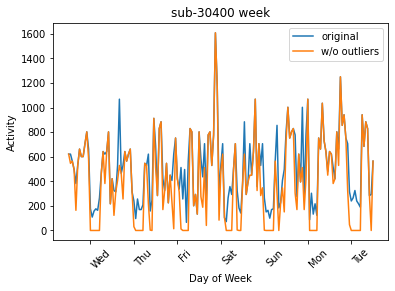

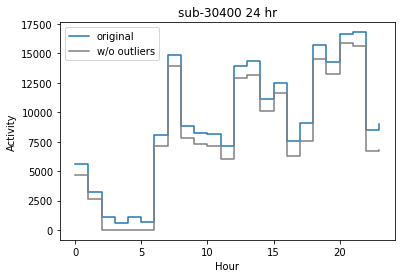

(24, 40)
successfully read Actiware data file
record 30403
30403 missing 0 values out of 40307 total (0.00 percent)
interpolated - now missing 0 values out of 40307 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


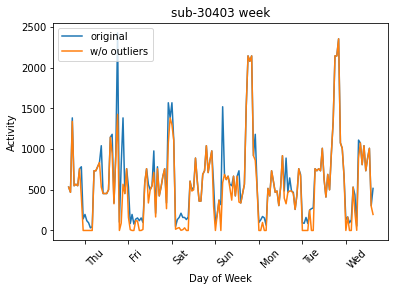

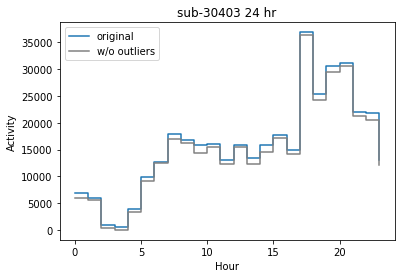

(24, 41)
successfully read Actiware data file
record 30407
30407 missing 0 values out of 31308 total (0.00 percent)
interpolated - now missing 0 values out of 31308 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


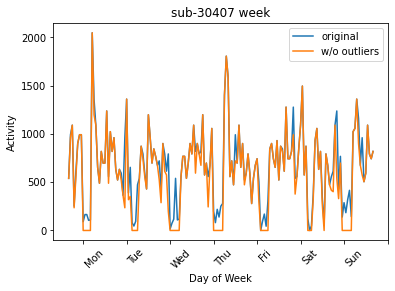

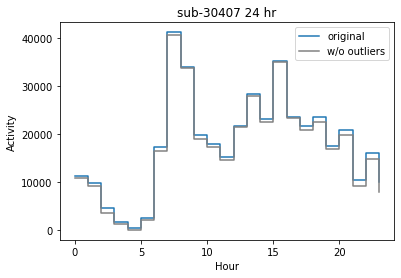

(24, 42)
successfully read Actiware data file
record 30412
30412 missing 0 values out of 40147 total (0.00 percent)
interpolated - now missing 0 values out of 40147 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


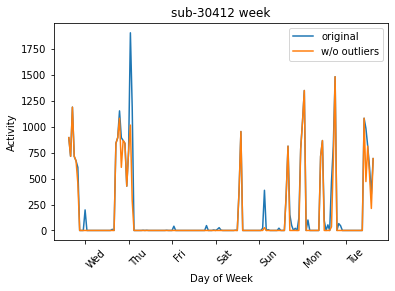

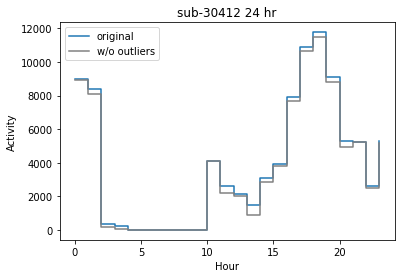

(24, 43)
successfully read Actiware data file
record 30417
30417 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


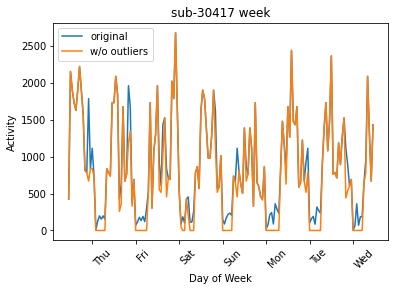

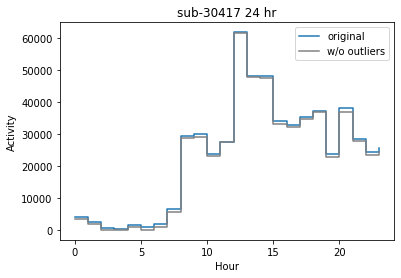

(24, 44)
successfully read Actiware data file
record 30426
30426 missing 0 values out of 40182 total (0.00 percent)
interpolated - now missing 0 values out of 40182 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


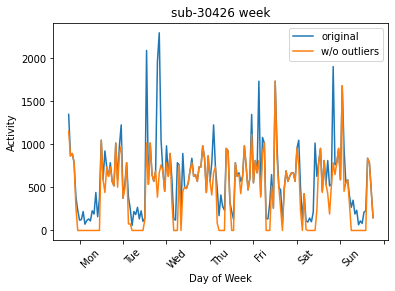

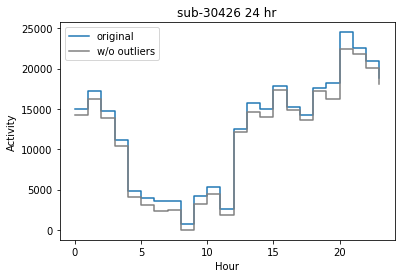

(24, 45)
successfully read Actiware data file
record 30432
30432 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


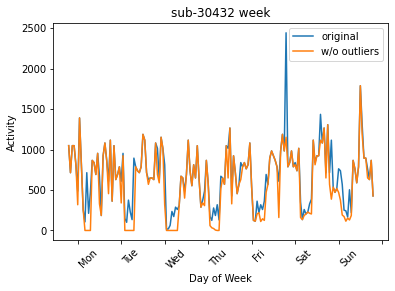

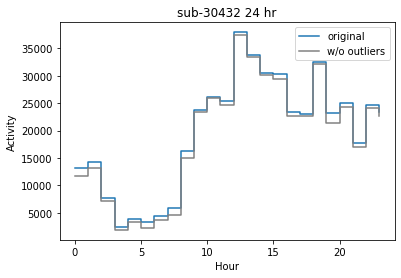

(24, 46)
successfully read Actiware data file
record 30433
30433 missing 0 values out of 40293 total (0.00 percent)
interpolated - now missing 0 values out of 40293 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


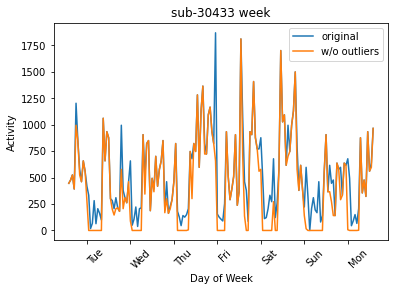

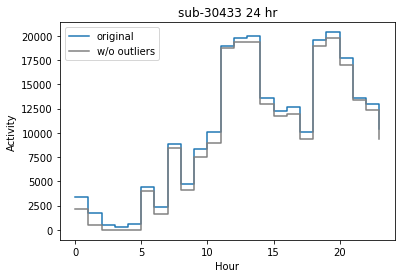

(24, 47)
successfully read Actiware data file
record 30466
30466 missing 0 values out of 32176 total (0.00 percent)
interpolated - now missing 0 values out of 32176 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


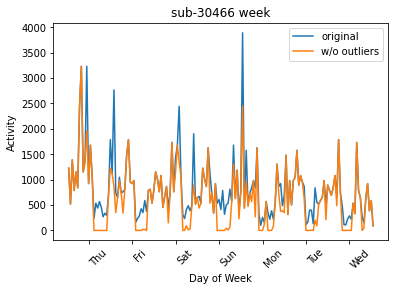

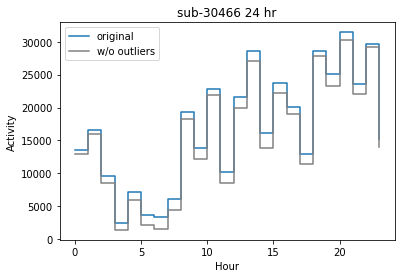

(24, 48)
successfully read Actiware data file
record 30469
30469 missing 0 values out of 39773 total (0.00 percent)
interpolated - now missing 0 values out of 39773 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


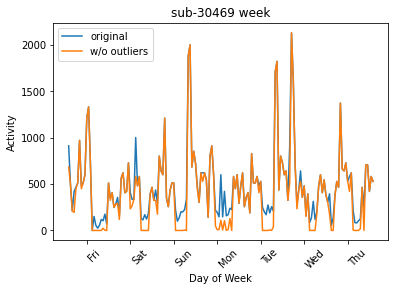

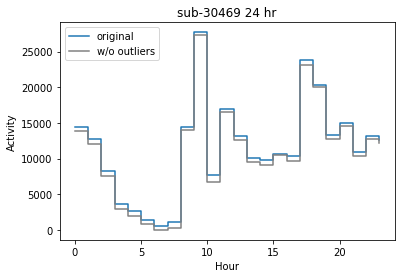

(24, 49)
successfully read Actiware data file
record 30476
30476 missing 0 values out of 32408 total (0.00 percent)
interpolated - now missing 0 values out of 32408 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


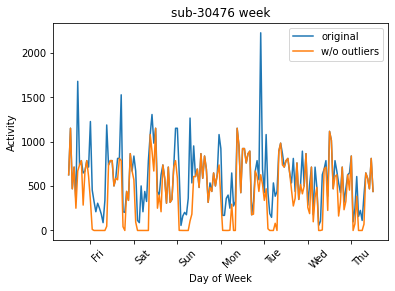

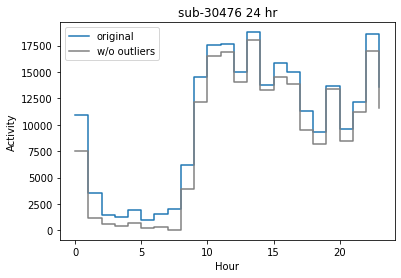

(24, 50)
successfully read Actiware data file
record 30478
30478 missing 0 values out of 40237 total (0.00 percent)
interpolated - now missing 0 values out of 40237 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


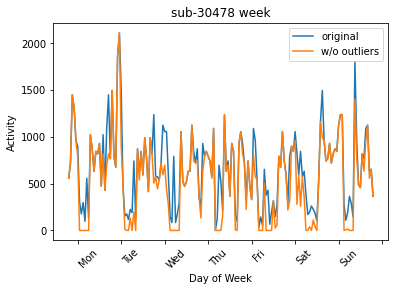

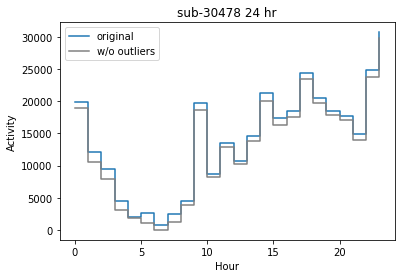

(24, 51)
successfully read Actiware data file
record 30568
30568 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


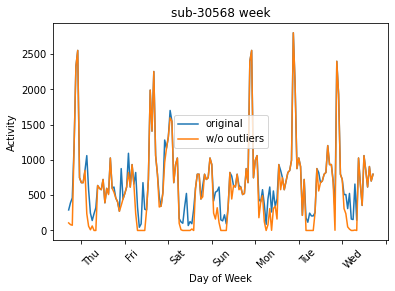

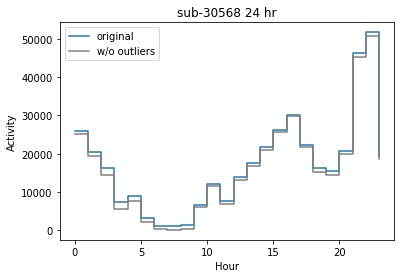

(24, 52)
successfully read Actiware data file
record 30570
30570 missing 0 values out of 34547 total (0.00 percent)
interpolated - now missing 0 values out of 34547 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


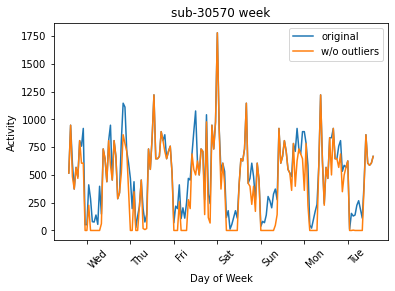

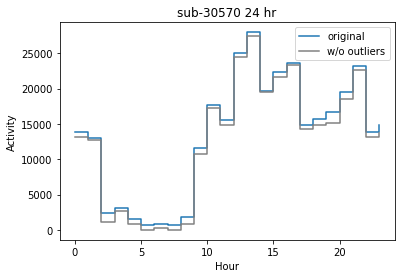

(24, 53)
successfully read Actiware data file
record 30581
30581 missing 0 values out of 29244 total (0.00 percent)
interpolated - now missing 0 values out of 29244 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


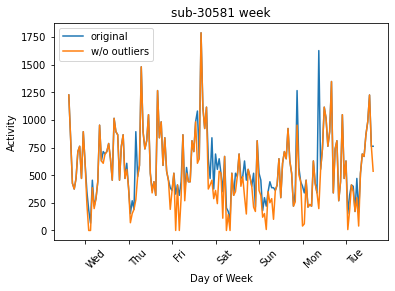

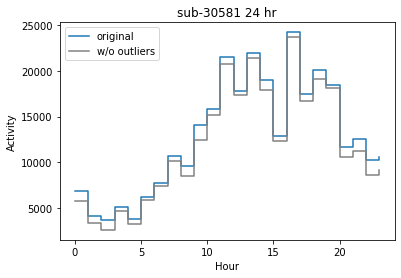

(24, 54)
successfully read Actiware data file
record 30584
30584 missing 0 values out of 40099 total (0.00 percent)
interpolated - now missing 0 values out of 40099 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


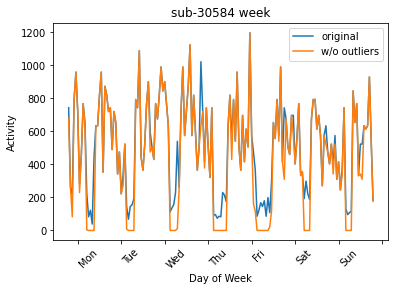

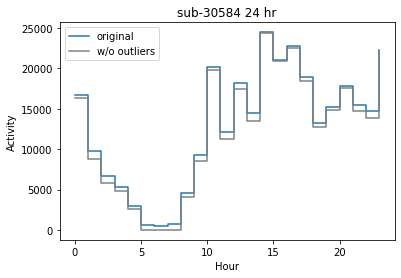

(24, 55)
successfully read Actiware data file
record 30588
30588 missing 0 values out of 21829 total (0.00 percent)
interpolated - now missing 0 values out of 21829 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


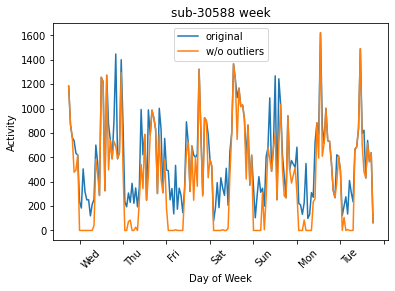

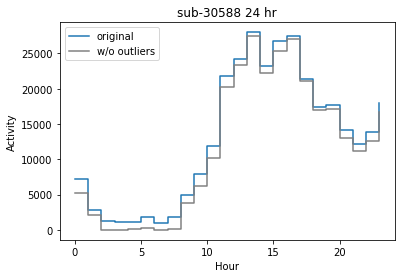

(24, 56)
successfully read Actiware data file
record 40160
40160 missing 0 values out of 20560 total (0.00 percent)
interpolated - now missing 0 values out of 20560 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


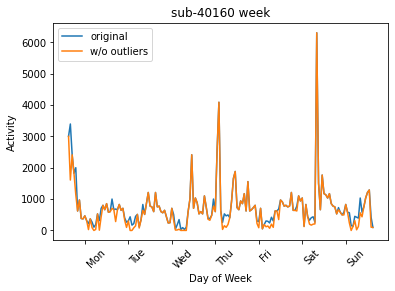

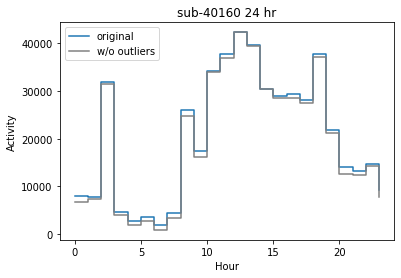

(24, 57)
successfully read Actiware data file
record 40160
40160 missing 0 values out of 37677 total (0.00 percent)
interpolated - now missing 0 values out of 37677 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


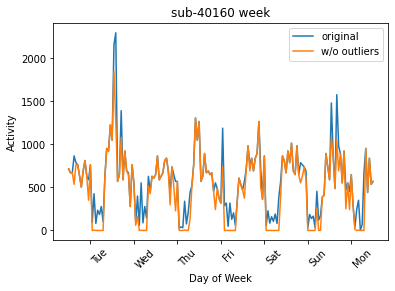

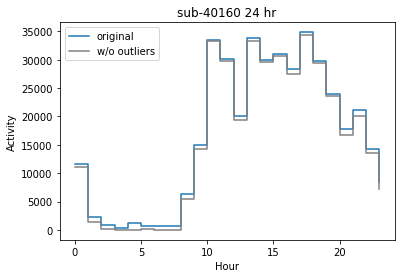

(24, 57)
successfully read Actiware data file
record 40170
40170 missing 0 values out of 31771 total (0.00 percent)
interpolated - now missing 0 values out of 31771 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


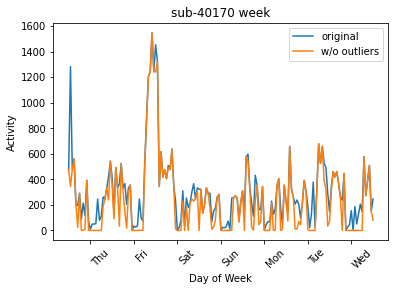

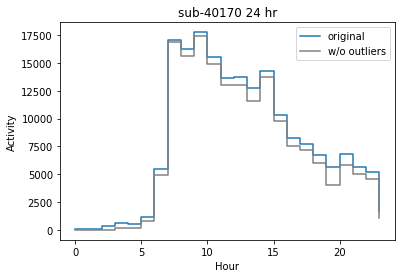

(24, 58)
successfully read Actiware data file
record 40175
40175 missing 0 values out of 40309 total (0.00 percent)
interpolated - now missing 0 values out of 40309 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


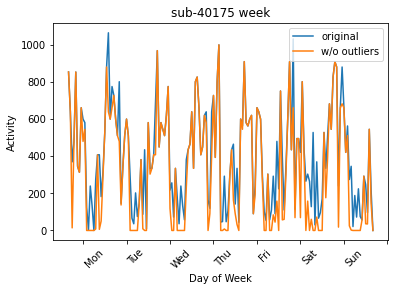

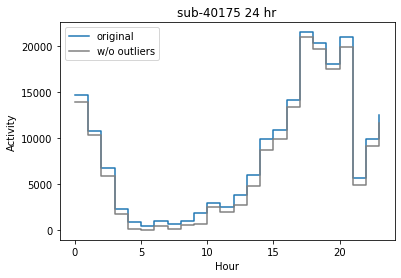

(24, 59)
successfully read Actiware data file
record 40288
40288 missing 0 values out of 40170 total (0.00 percent)
interpolated - now missing 0 values out of 40170 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


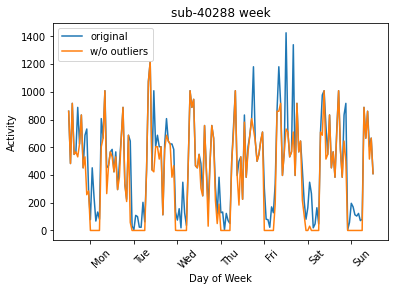

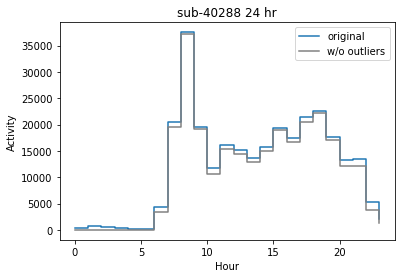

(24, 60)
successfully read Actiware data file
record 40351
40351 missing 0 values out of 29423 total (0.00 percent)
interpolated - now missing 0 values out of 29423 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


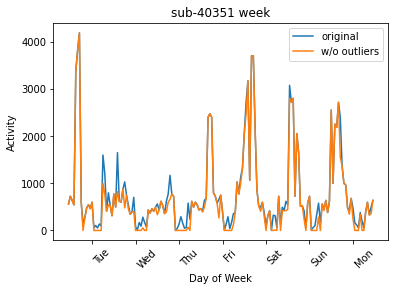

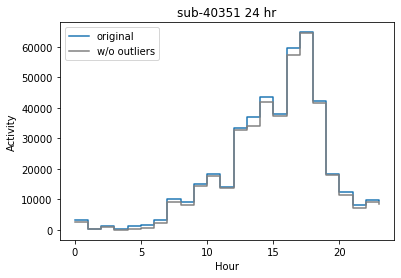

(24, 61)
successfully read Actiware data file
record 40490
40490 missing 0 values out of 35015 total (0.00 percent)
interpolated - now missing 0 values out of 35015 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


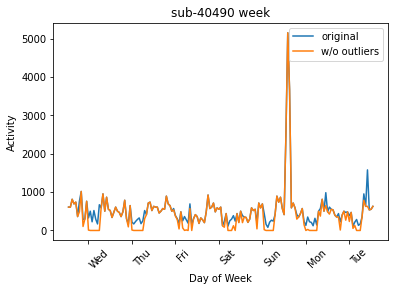

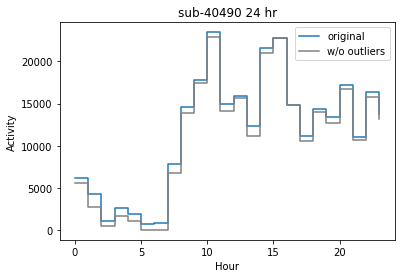

(24, 62)
successfully read Actiware data file
record 40496
40496 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


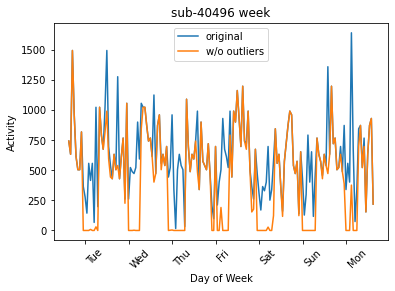

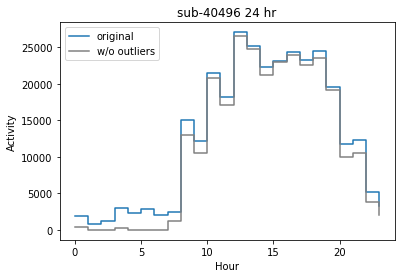

(24, 63)
successfully read Actiware data file
record 40500
40500 missing 0 values out of 34786 total (0.00 percent)
interpolated - now missing 0 values out of 34786 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


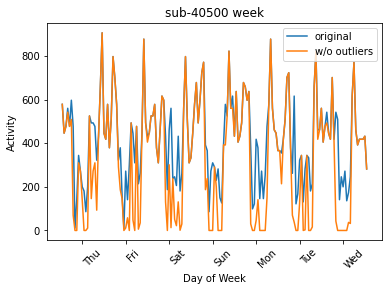

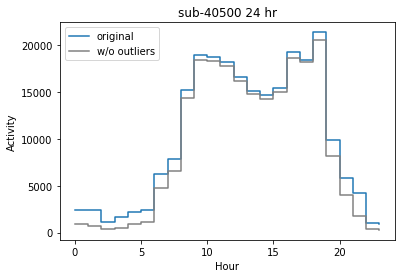

(24, 64)
successfully read Actiware data file
record 40511
40511 missing 0 values out of 36850 total (0.00 percent)
interpolated - now missing 0 values out of 36850 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


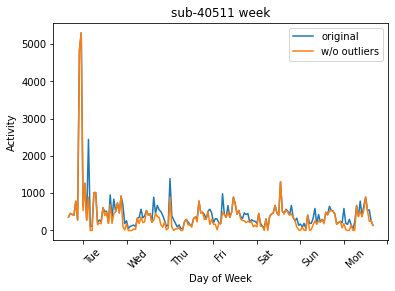

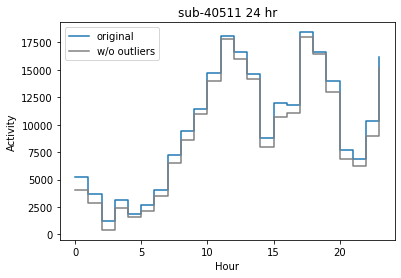

(24, 65)
successfully read Actiware data file
record 40512
40512 missing 0 values out of 20679 total (0.00 percent)
interpolated - now missing 0 values out of 20679 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


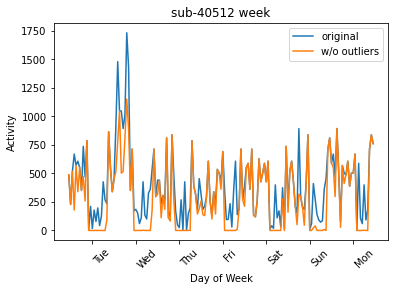

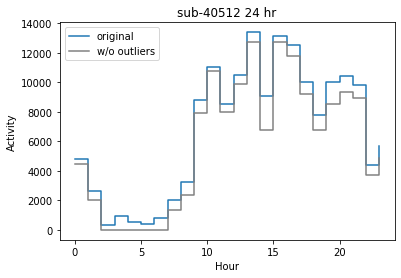

(24, 66)
successfully read Actiware data file
record 40515
40515 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


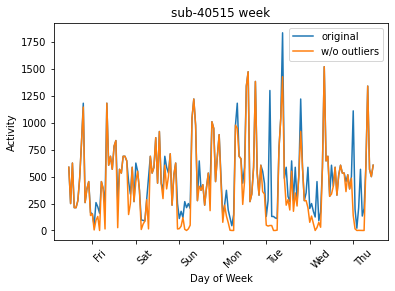

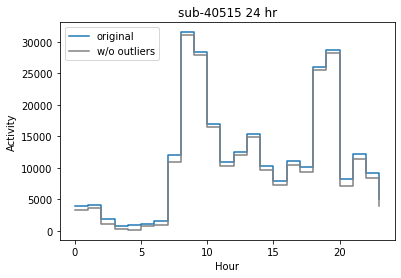

(24, 67)
successfully read Actiware data file
record 40516
40516 missing 0 values out of 39762 total (0.00 percent)
interpolated - now missing 0 values out of 39762 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


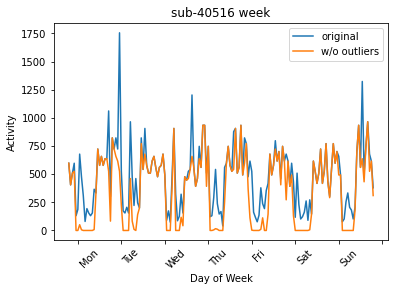

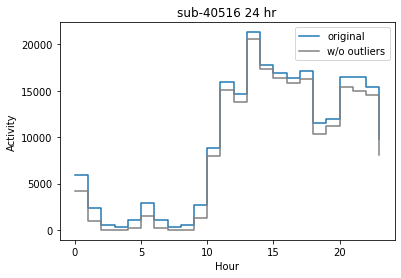

(24, 68)
successfully read Actiware data file
record 40519
40519 missing 0 values out of 37402 total (0.00 percent)
interpolated - now missing 0 values out of 37402 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


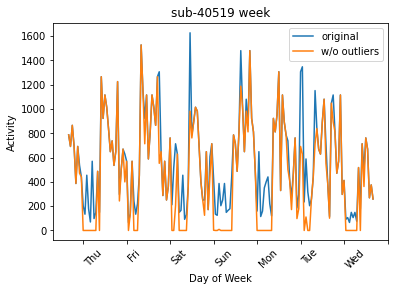

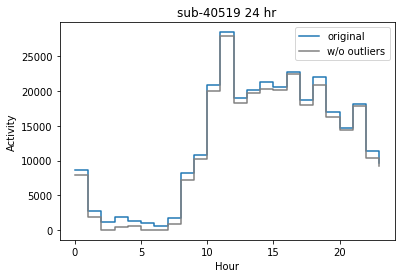

(24, 69)
successfully read Actiware data file
record 40520
40520 missing 0 values out of 40163 total (0.00 percent)
interpolated - now missing 0 values out of 40163 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


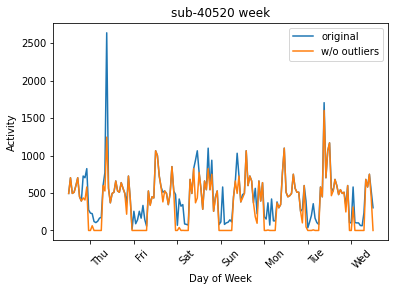

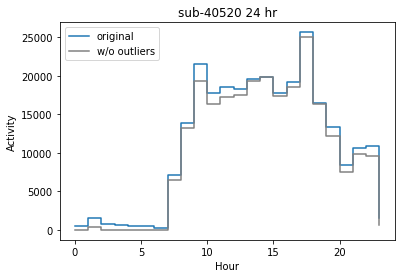

(24, 70)
successfully read Actiware data file
record 40522
40522 missing 0 values out of 40247 total (0.00 percent)
interpolated - now missing 0 values out of 40247 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


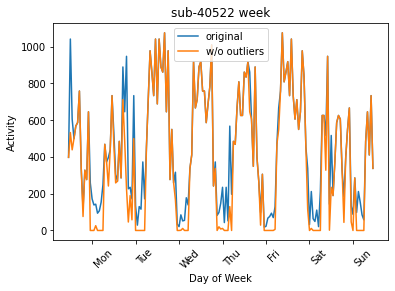

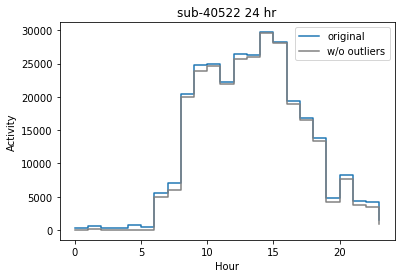

(24, 71)
successfully read Actiware data file
record 40524
40524 missing 0 values out of 40299 total (0.00 percent)
interpolated - now missing 0 values out of 40299 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


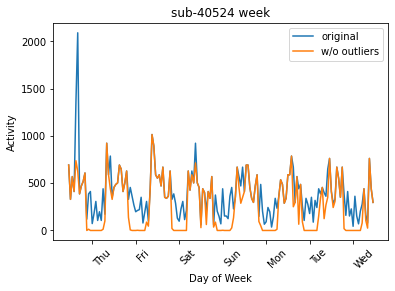

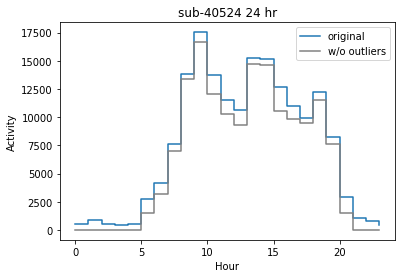

(24, 72)
successfully read Actiware data file
record 40538
40538 missing 0 values out of 22609 total (0.00 percent)
interpolated - now missing 0 values out of 22609 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


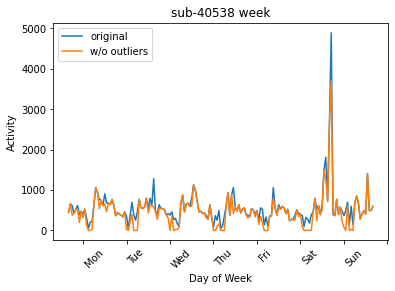

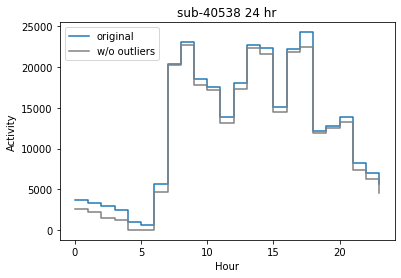

(24, 73)
successfully read Actiware data file
record 40547
40547 missing 0 values out of 40251 total (0.00 percent)
interpolated - now missing 0 values out of 40251 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


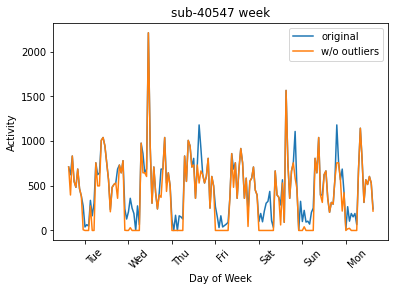

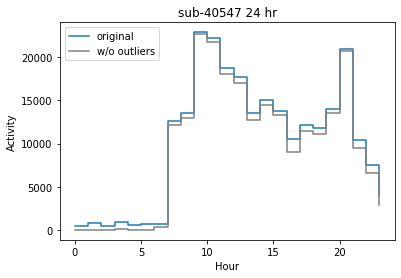

(24, 74)
successfully read Actiware data file
record 40547
40547 missing 0 values out of 34482 total (0.00 percent)
interpolated - now missing 0 values out of 34482 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


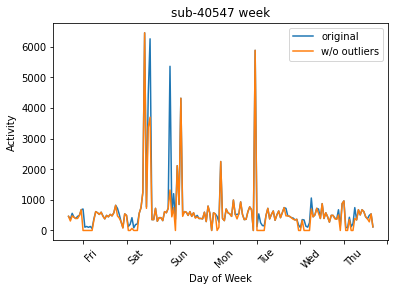

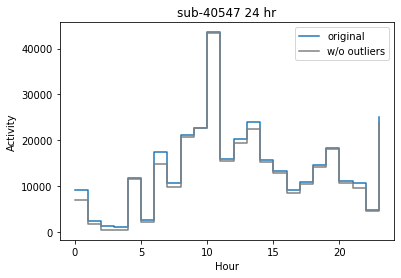

(24, 74)
successfully read Actiware data file
record 40550
40550 missing 0 values out of 40311 total (0.00 percent)
interpolated - now missing 0 values out of 40311 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


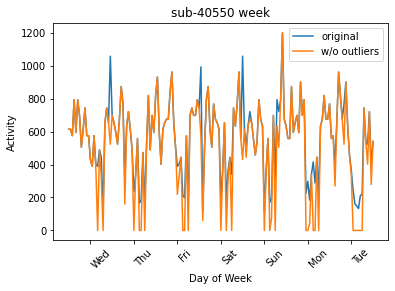

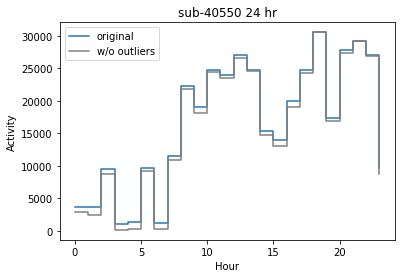

(24, 75)
successfully read Actiware data file
record 40564
40564 missing 0 values out of 37716 total (0.00 percent)
interpolated - now missing 0 values out of 37716 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


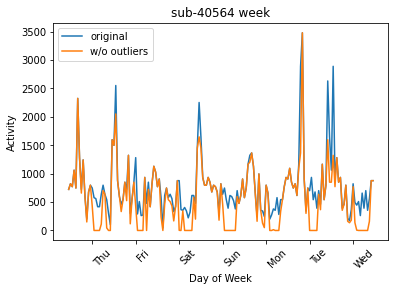

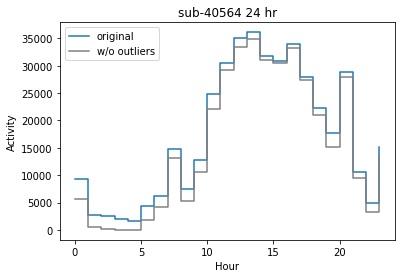

(24, 76)
successfully read Actiware data file
record 40601
40601 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


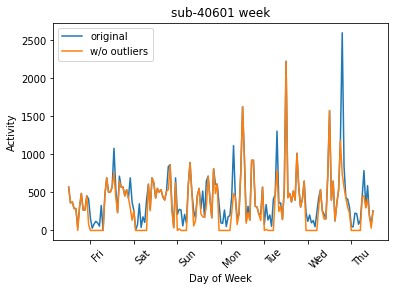

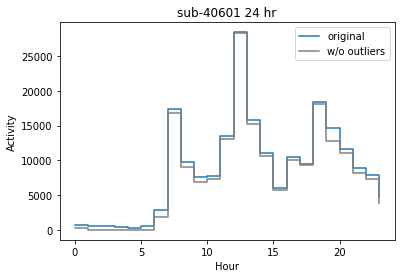

(24, 77)
successfully read Actiware data file
record 40608
40608 missing 0 values out of 35320 total (0.00 percent)
interpolated - now missing 0 values out of 35320 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


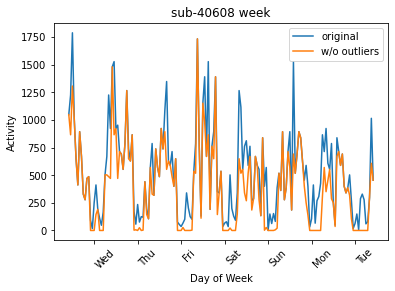

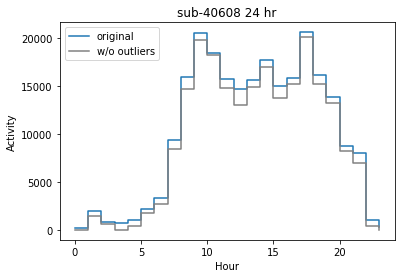

(24, 78)
successfully read Actiware data file
record 40615
40615 missing 0 values out of 40318 total (0.00 percent)
interpolated - now missing 0 values out of 40318 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


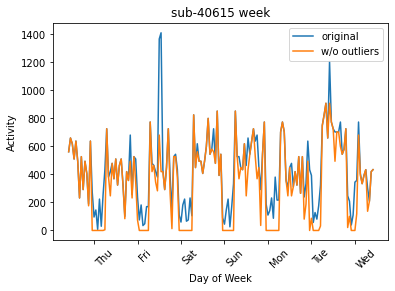

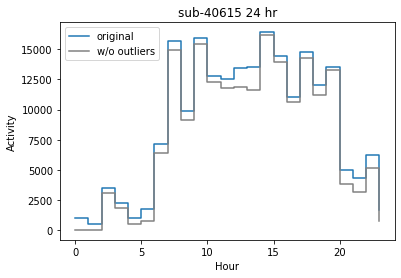

(24, 79)
successfully read Actiware data file
record 40619
40619 missing 0 values out of 29087 total (0.00 percent)
interpolated - now missing 0 values out of 29087 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


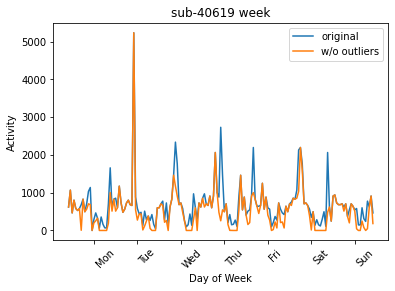

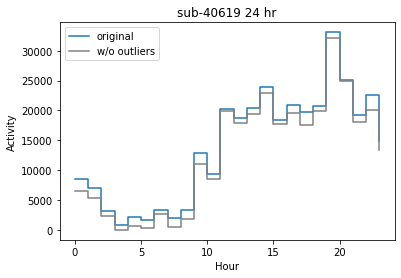

(24, 80)
successfully read Actiware data file
record 40623
40623 missing 0 values out of 38013 total (0.00 percent)
interpolated - now missing 0 values out of 38013 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


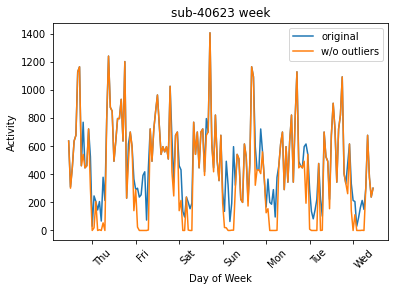

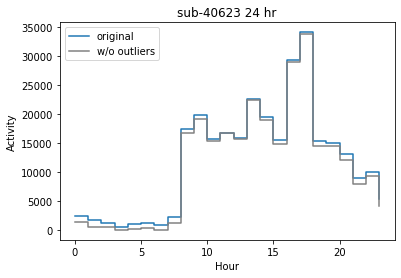

(24, 81)
successfully read Actiware data file
record 40629
40629 missing 0 values out of 40215 total (0.00 percent)
interpolated - now missing 0 values out of 40215 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


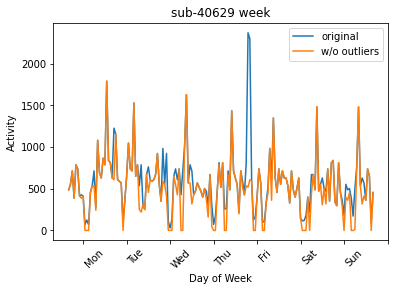

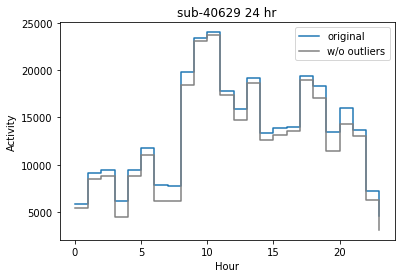

(24, 82)
successfully read Actiware data file
record 40638
40638 missing 0 values out of 37843 total (0.00 percent)
interpolated - now missing 0 values out of 37843 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


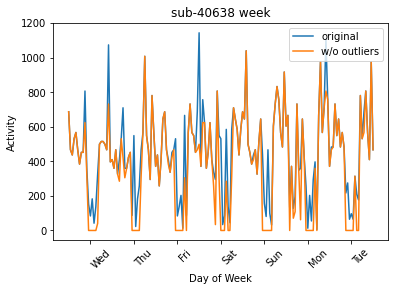

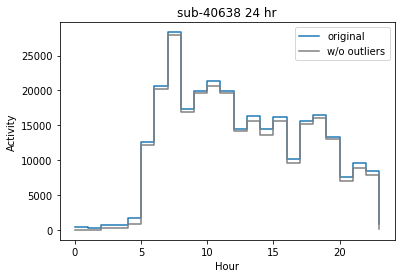

(24, 83)
successfully read Actiware data file
record 40649
40649 missing 0 values out of 21839 total (0.00 percent)
interpolated - now missing 0 values out of 21839 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


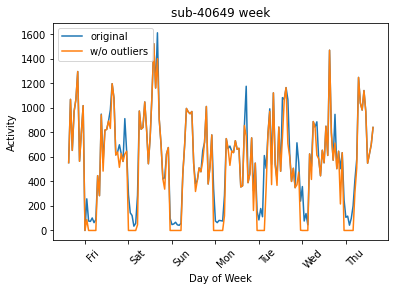

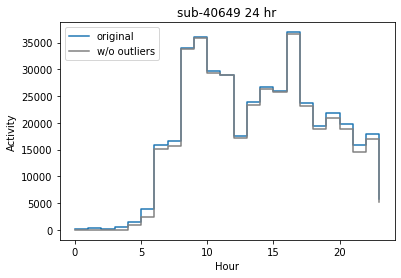

(24, 84)
successfully read Actiware data file
record 40650
40650 missing 0 values out of 31822 total (0.00 percent)
interpolated - now missing 0 values out of 31822 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


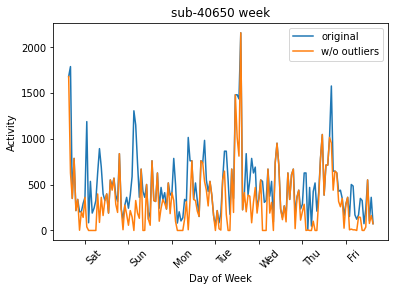

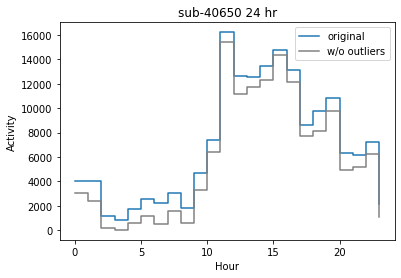

(24, 85)
successfully read Actiware data file
record 40653
40653 missing 0 values out of 30324 total (0.00 percent)
interpolated - now missing 0 values out of 30324 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


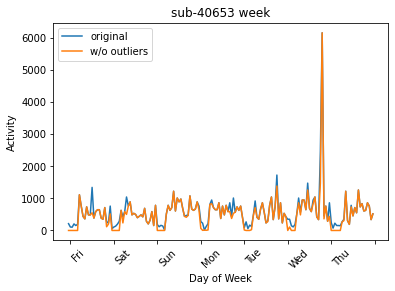

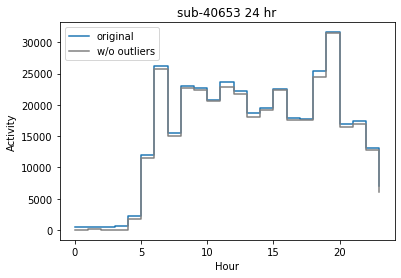

(24, 86)
successfully read Actiware data file
record 40655
40655 missing 0 values out of 37963 total (0.00 percent)
interpolated - now missing 0 values out of 37963 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


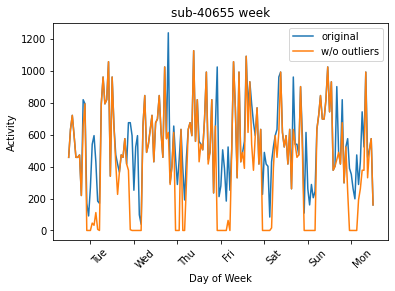

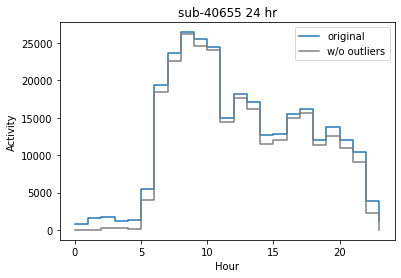

(24, 87)
successfully read Actiware data file
record 40656
40656 missing 0 values out of 40312 total (0.00 percent)
interpolated - now missing 0 values out of 40312 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


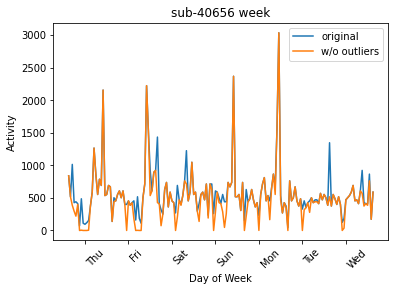

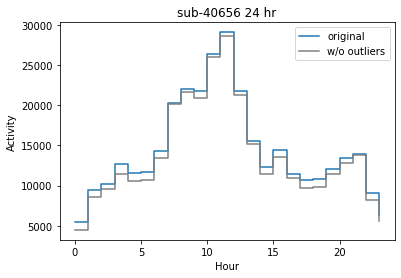

(24, 88)
successfully read Actiware data file
record 40658
40658 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


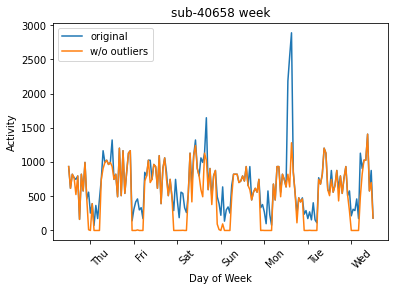

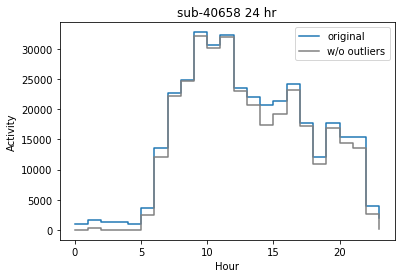

(24, 89)
successfully read Actiware data file
record 40664
40664 missing 0 values out of 32254 total (0.00 percent)
interpolated - now missing 0 values out of 32254 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


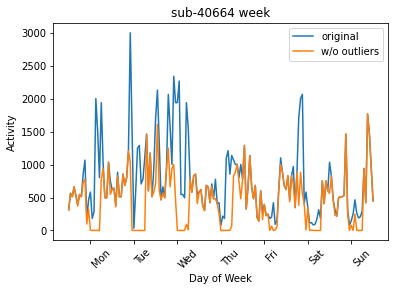

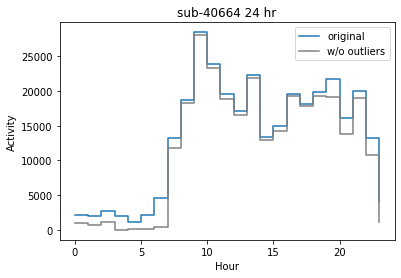

(24, 90)
successfully read Actiware data file
record 40665
40665 missing 0 values out of 40133 total (0.00 percent)
interpolated - now missing 0 values out of 40133 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


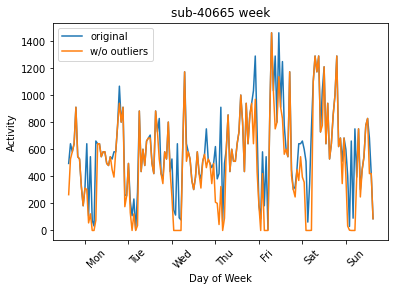

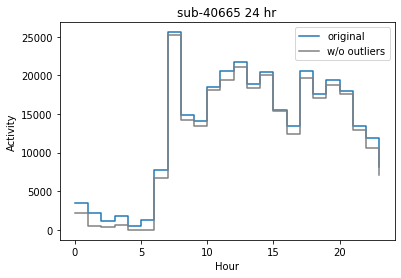

(24, 91)
successfully read Actiware data file
record 40668
40668 missing 0 values out of 31564 total (0.00 percent)
interpolated - now missing 0 values out of 31564 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


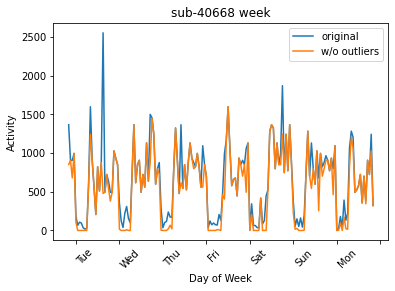

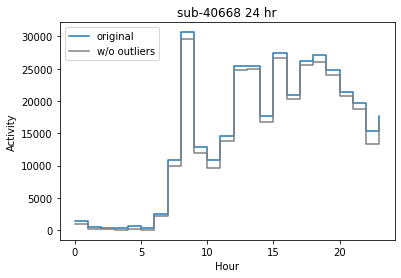

(24, 92)
successfully read Actiware data file
record 40672
40672 missing 0 values out of 31772 total (0.00 percent)
interpolated - now missing 0 values out of 31772 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


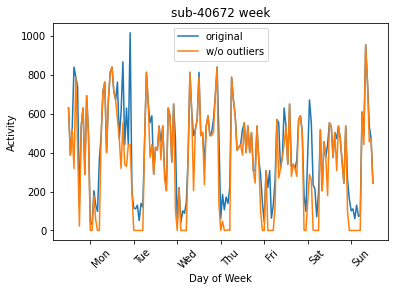

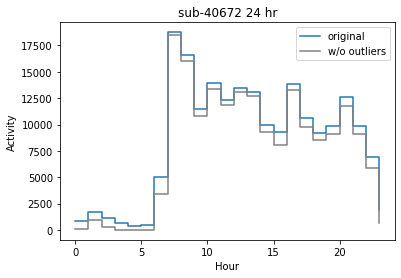

(24, 93)
successfully read Actiware data file
record 40685
40685 missing 0 values out of 28623 total (0.00 percent)
interpolated - now missing 0 values out of 28623 total (0.0 percent)
----- success: 0.00 percent NaN, 9 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


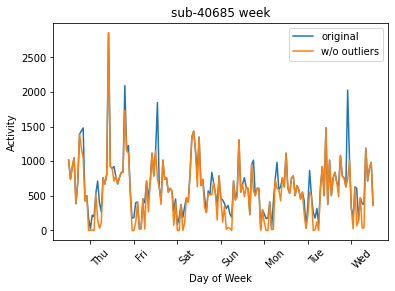

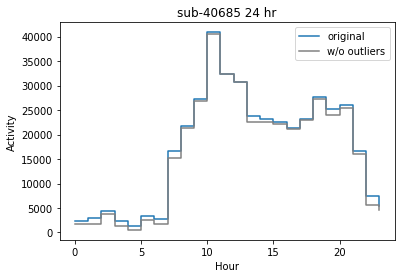

(24, 94)
successfully read Actiware data file
record 40694
40694 missing 0 values out of 34676 total (0.00 percent)
interpolated - now missing 0 values out of 34676 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


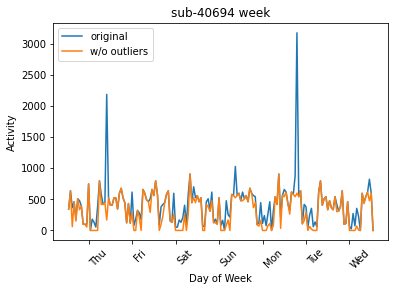

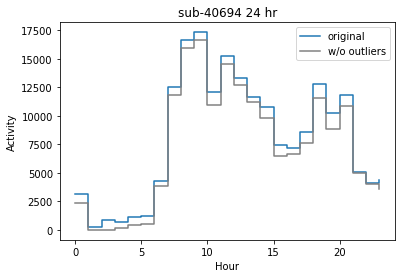

(24, 95)
successfully read Actiware data file
record 40707
40707 missing 0 values out of 34508 total (0.00 percent)
interpolated - now missing 0 values out of 34508 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


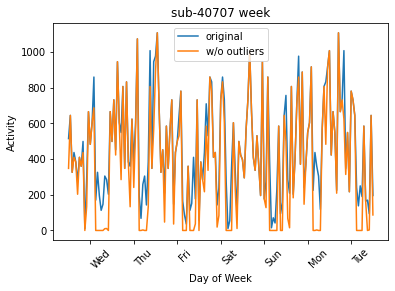

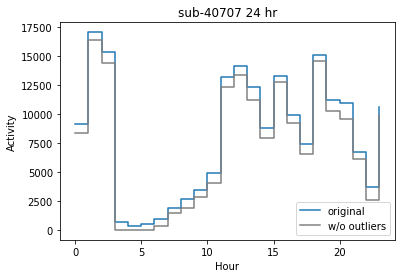

(24, 96)
successfully read Actiware data file
record 40720
40720 missing 0 values out of 39995 total (0.00 percent)
interpolated - now missing 0 values out of 39995 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


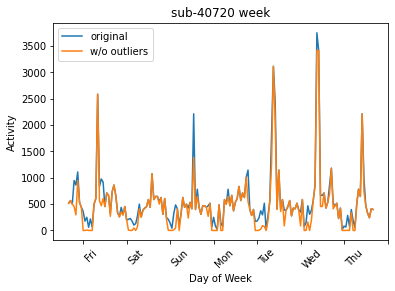

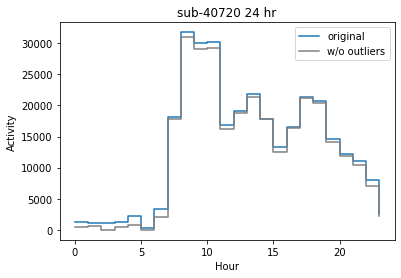

(24, 97)
successfully read Actiware data file
record 40728
40728 missing 0 values out of 40278 total (0.00 percent)
interpolated - now missing 0 values out of 40278 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


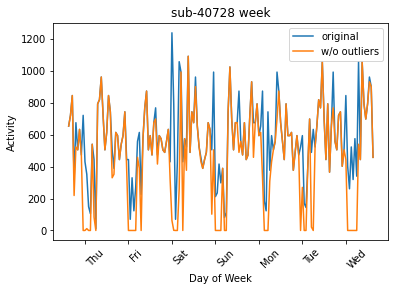

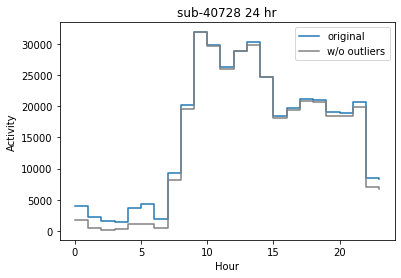

(24, 98)
successfully read Actiware data file
record 40730
40730 missing 0 values out of 40255 total (0.00 percent)
interpolated - now missing 0 values out of 40255 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


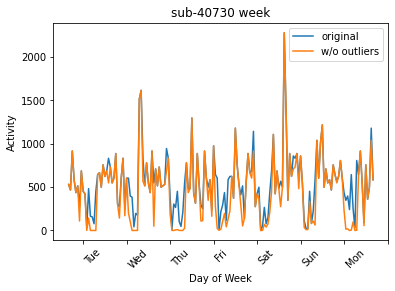

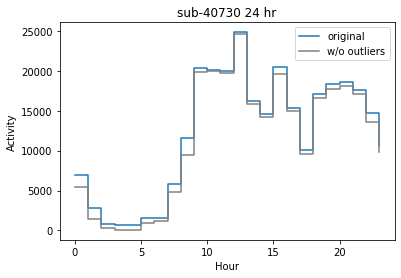

(24, 99)
successfully read Actiware data file
record 40733
40733 missing 0 values out of 37582 total (0.00 percent)
interpolated - now missing 0 values out of 37582 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


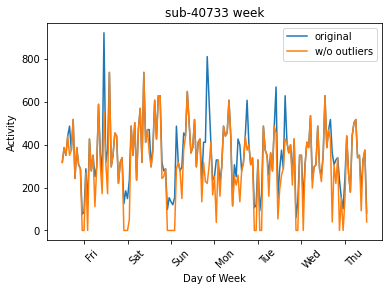

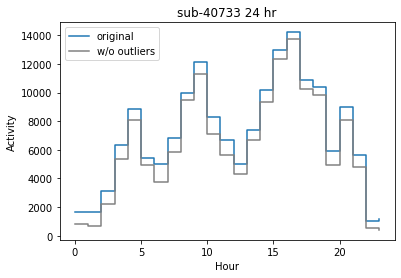

(24, 100)
successfully read Actiware data file
record 40738
40738 missing 0 values out of 37749 total (0.00 percent)
interpolated - now missing 0 values out of 37749 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


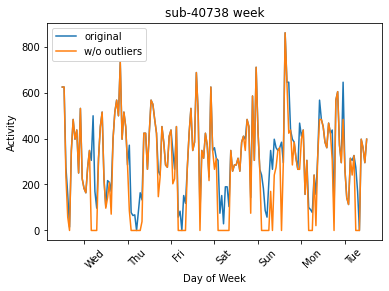

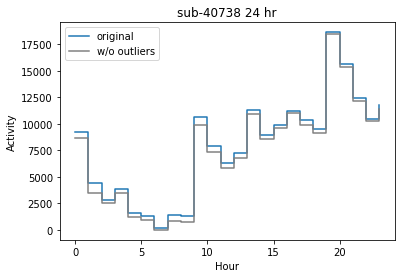

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 101)
successfully read Actiware data file
record 40750
40750 missing 0 values out of 31131 total (0.00 percent)
interpolated - now missing 0 values out of 31131 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


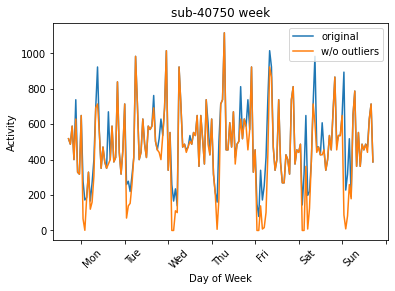

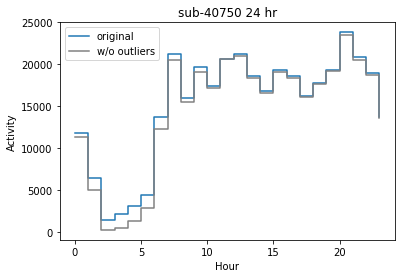

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 102)
successfully read Actiware data file
record 40756
40756 missing 0 values out of 20212 total (0.00 percent)
interpolated - now missing 0 values out of 20212 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


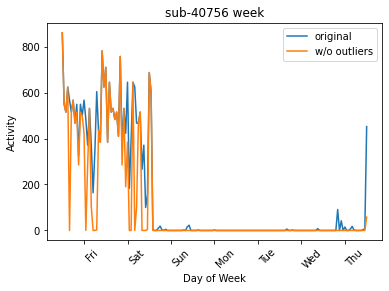

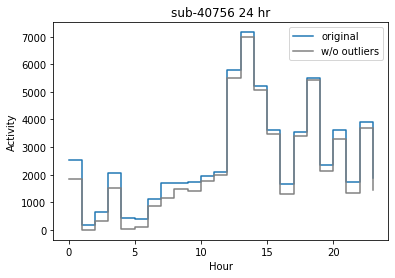

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 103)
successfully read Actiware data file
record 40758
40758 missing 0 values out of 37659 total (0.00 percent)
interpolated - now missing 0 values out of 37659 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


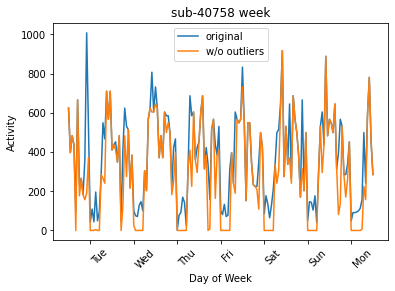

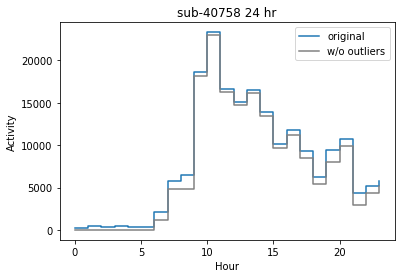

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 104)
successfully read Actiware data file
record 40767
40767 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


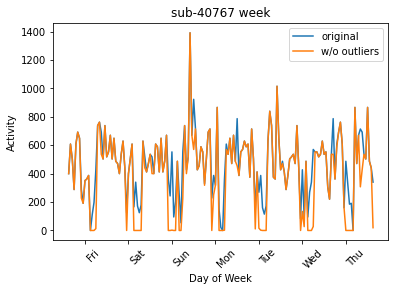

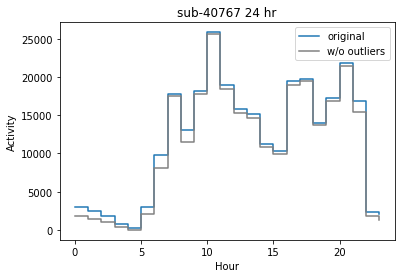

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 105)
successfully read Actiware data file
record 40768
40768 missing 0 values out of 40261 total (0.00 percent)
interpolated - now missing 0 values out of 40261 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


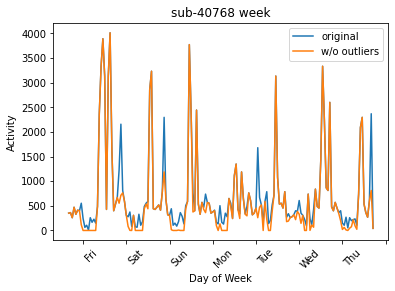

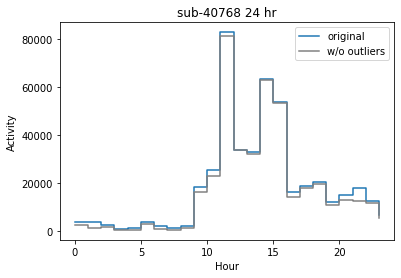

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 106)
successfully read Actiware data file
record 40769
40769 missing 0 values out of 40278 total (0.00 percent)
interpolated - now missing 0 values out of 40278 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


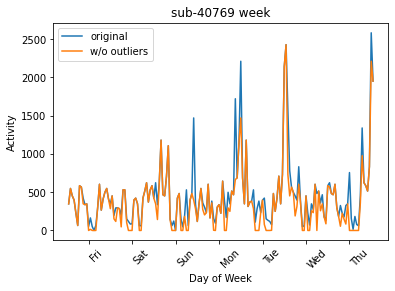

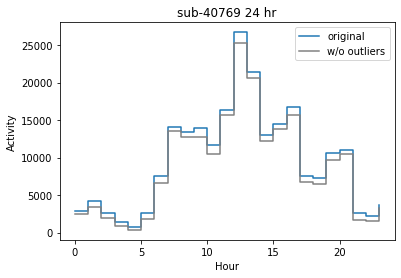

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 107)
successfully read Actiware data file
record 40773
40773 missing 0 values out of 35185 total (0.00 percent)
interpolated - now missing 0 values out of 35185 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


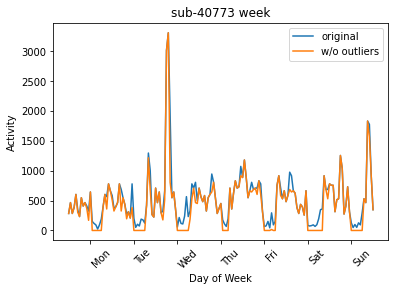

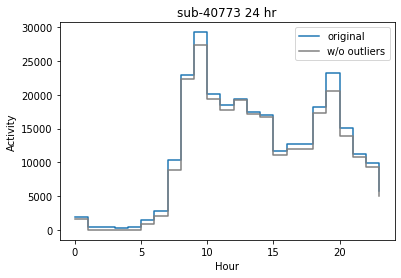

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 108)
successfully read Actiware data file
record 40775
40775 missing 0 values out of 29016 total (0.00 percent)
interpolated - now missing 0 values out of 29016 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


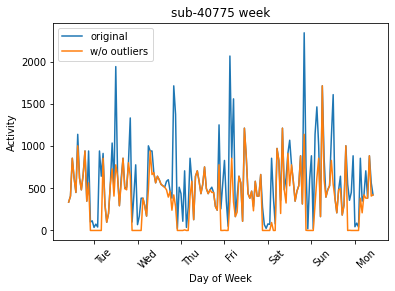

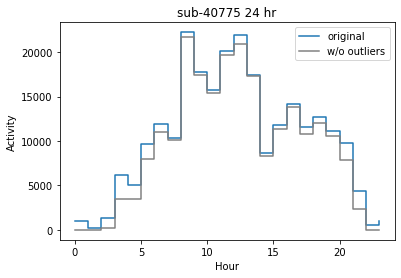

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 109)
successfully read Actiware data file
record 40777
40777 missing 0 values out of 37239 total (0.00 percent)
interpolated - now missing 0 values out of 37239 total (0.0 percent)
----- success: 0.00 percent NaN, 12 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


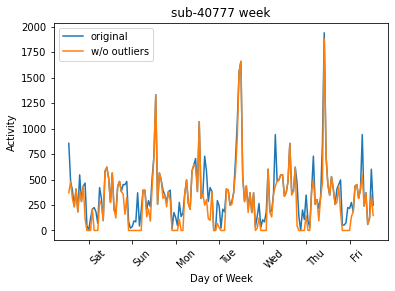

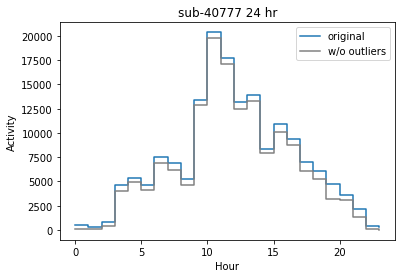

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 110)
successfully read Actiware data file
record 40778
40778 missing 0 values out of 31879 total (0.00 percent)
interpolated - now missing 0 values out of 31879 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


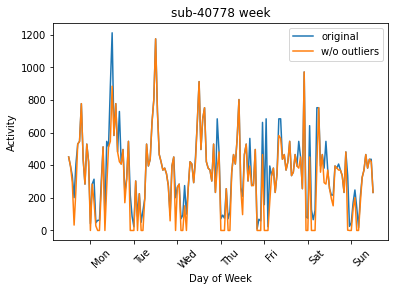

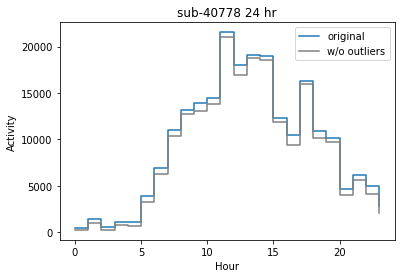

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 111)
successfully read Actiware data file
record 40779
40779 missing 0 values out of 39861 total (0.00 percent)
interpolated - now missing 0 values out of 39861 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


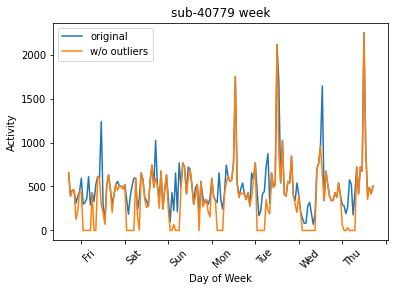

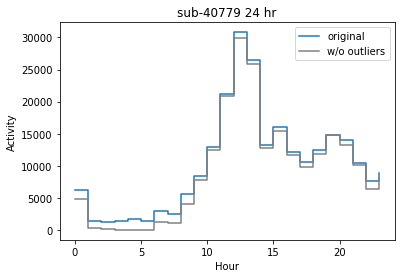

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 112)
successfully read Actiware data file
record 40782
40782 missing 0 values out of 40088 total (0.00 percent)
interpolated - now missing 0 values out of 40088 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


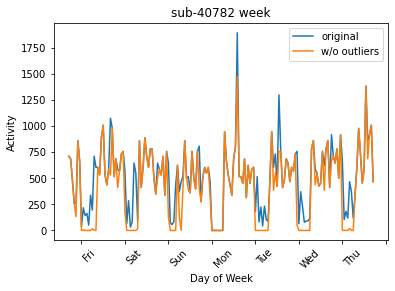

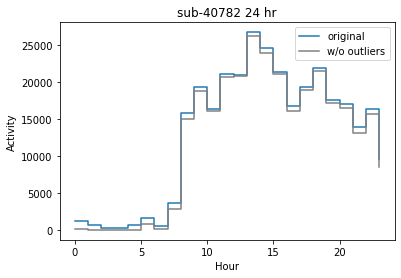

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 113)
successfully read Actiware data file
record 40784
40784 missing 0 values out of 37492 total (0.00 percent)
interpolated - now missing 0 values out of 37492 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


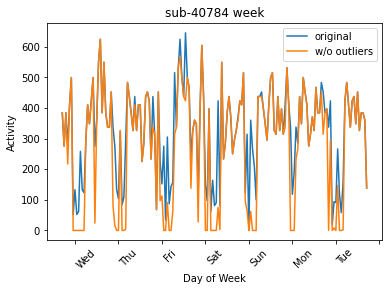

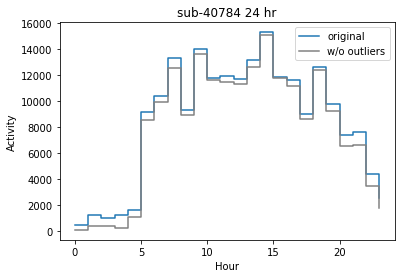

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 114)
successfully read Actiware data file
record 40788
40788 missing 0 values out of 37767 total (0.00 percent)
interpolated - now missing 0 values out of 37767 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


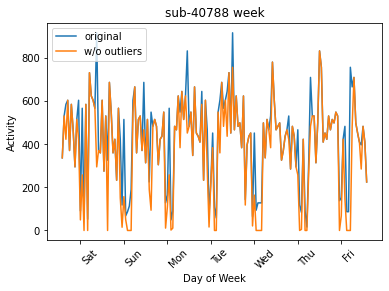

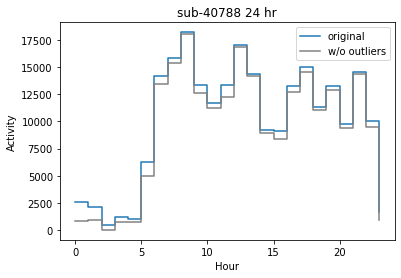

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 115)
successfully read Actiware data file
record 40796
40796 missing 0 values out of 40265 total (0.00 percent)
interpolated - now missing 0 values out of 40265 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


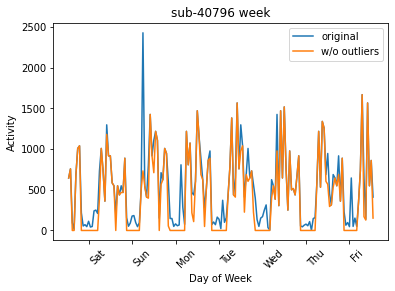

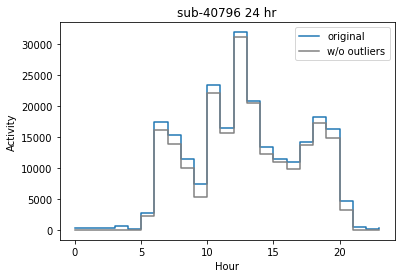

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 116)
successfully read Actiware data file
record 40803
40803 missing 0 values out of 34525 total (0.00 percent)
interpolated - now missing 0 values out of 34525 total (0.0 percent)
----- success: 0.00 percent NaN, 11 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


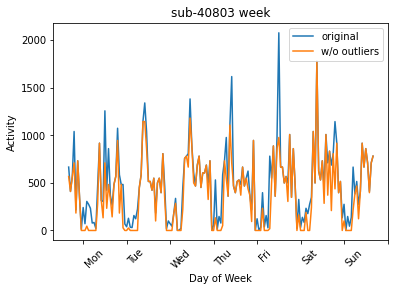

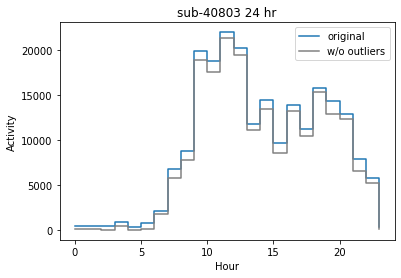

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 117)
successfully read Actiware data file
record 40811
40811 missing 0 values out of 40318 total (0.00 percent)
interpolated - now missing 0 values out of 40318 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


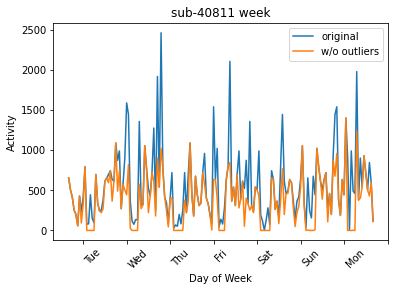

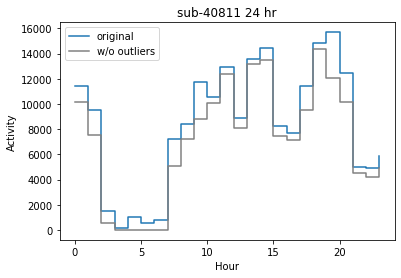

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 118)
successfully read Actiware data file
record 40825
40825 missing 0 values out of 40318 total (0.00 percent)
interpolated - now missing 0 values out of 40318 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


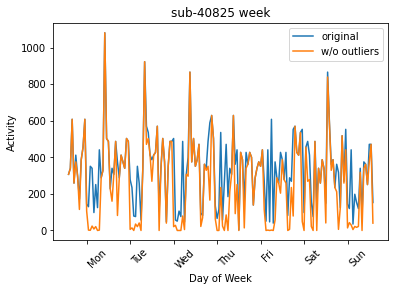

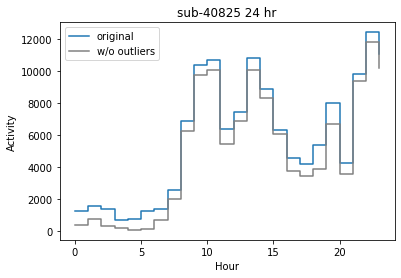

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 119)
successfully read Actiware data file
record 40855
40855 missing 0 values out of 40319 total (0.00 percent)
interpolated - now missing 0 values out of 40319 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


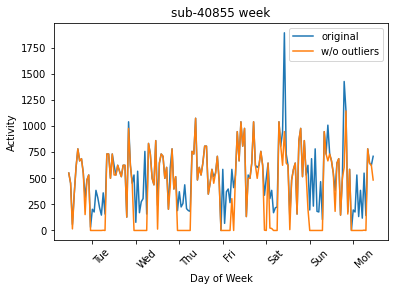

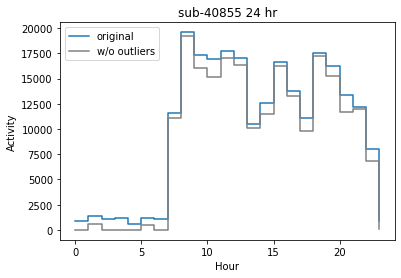

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 120)
successfully read Actiware data file
record 40859
40859 missing 0 values out of 29425 total (0.00 percent)
interpolated - now missing 0 values out of 29425 total (0.0 percent)
----- success: 0.00 percent NaN, 10 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


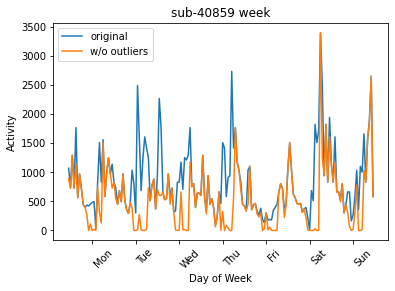

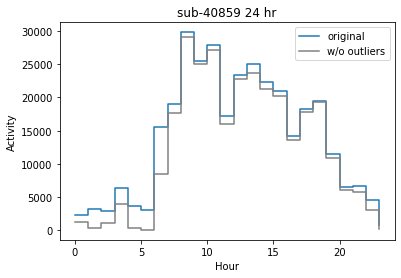

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 121)
successfully read Actiware data file
record 40861
40861 missing 0 values out of 37464 total (0.00 percent)
interpolated - now missing 0 values out of 37464 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


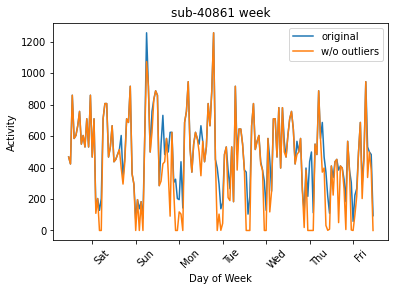

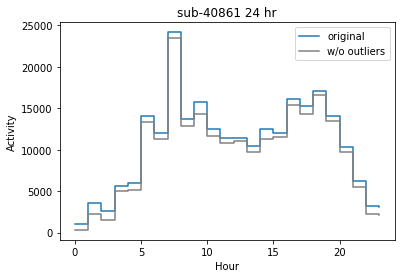

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 122)
successfully read Actiware data file
record 40876
40876 missing 0 values out of 40307 total (0.00 percent)
interpolated - now missing 0 values out of 40307 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


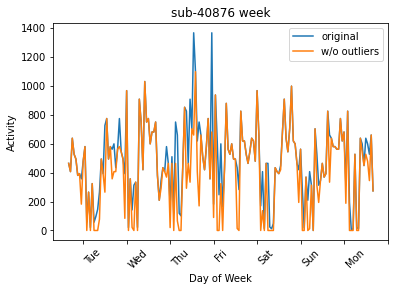

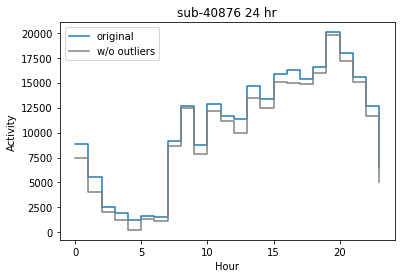

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 123)
successfully read Actiware data file
record 40878
40878 missing 0 values out of 40147 total (0.00 percent)
interpolated - now missing 0 values out of 40147 total (0.0 percent)
----- success: 0.00 percent NaN, 13 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


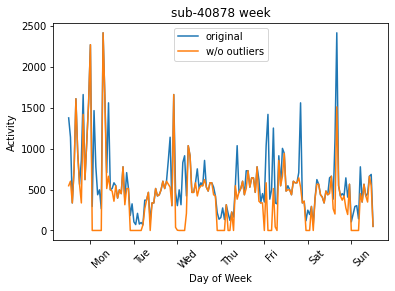

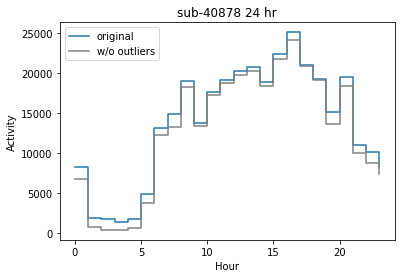

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


(24, 124)
successfully read Actiware data file
record 40891
40891 missing 0 values out of 21821 total (0.00 percent)
interpolated - now missing 0 values out of 21821 total (0.0 percent)
----- success: 0.00 percent NaN, 7 recording period


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')


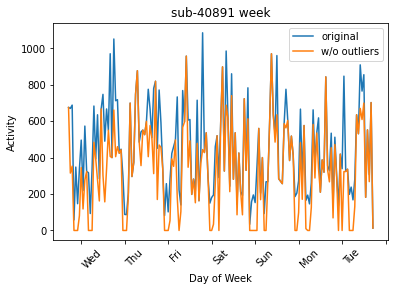

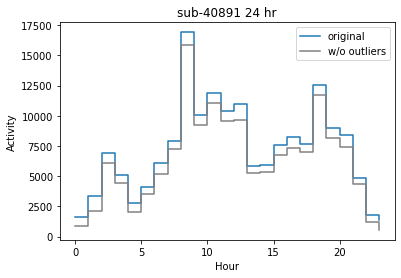

(24, 125)


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_18165/752698654.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  actdf[subject] = act24.values


In [18]:
actdf = pd.DataFrame()

weekday_map= {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu',
              4:'Fri', 5:'Sat', 6:'Sun'}

for file in actig_files:
    
    subject = file.split('raw/')[1][:5]
#     print(subject)
    
    # read in actigraphy data
    act = preproc.preproc(file, 'actiwatch', sr='.5T', truncate=False, write=True, plot=True, recording_period_min=7)
    
    start = act[act > 0].index[0]
    act = act[start:]
    
    # keep only seven days of data
    act = act[act.index <= (act.index[2] + pd.Timedelta(days=7))]
    
    # interpolate outliers
    act0 = act.copy()
    act = hampel(act, window_size=10, n=5, imputation=True)
    
    x_dates = [ weekday_map[day] for day in act.index.dayofweek.unique() ]
    
    # plot
    fig, ax = plt.subplots()
    sns.lineplot(x=act0.resample('60min').max().index, y=act0.resample('60min').max(), label='original').set(title='sub-%s week' % subject)
    sns.lineplot(x=act.resample('60min').max().index, y=act.resample('60min').max(), label = 'w/o outliers').set(title='sub-%s week' % subject)
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')
    ax.set_xlabel('Day of Week'); ax.set_ylabel('Activity')
    plt.show()
    
    # if subject has < 7 days data, discard, else add to dataset
    if ( (act.last_valid_index() - act.first_valid_index()) >= pd.Timedelta(days=7) ):
        
        # bin into hours and take activity mean
        act = act.resample('60min').sum()
#         print(act.head())
        act24 = act.groupby(act.index.hour).mean()
        act24_0 = act0.resample('60min').sum().groupby(act.index.hour).mean()
#         print(act24.head())
        
        # plot
        fig, ax = plt.subplots()
        sns.lineplot(x=act24.index, y=act24_0, drawstyle='steps-post', label='original').set(title='sub-%s 24 hr' % subject)
        sns.lineplot(x=act24.index, y=act24, drawstyle='steps-post', label='w/o outliers', color='gray')
#         ax.set_xticklabels(labels=x_dates, rotation=45, ha='left')
        ax.set_xlabel('Hour'); ax.set_ylabel('Activity')
        plt.show()
        
        actdf[subject] = act24.values
        print(actdf.shape)
    
    else:
        
        print('sub-%s discarded, recording period %s days' % 
              (subject, act.last_valid_index() - act.first_valid_index()))


In [21]:
actdf.to_csv('/Users/mcmahonmc/Github/machine-learning-2021/final_project/data/actigraphy_data_24hrday_df.csv', index=False)

<AxesSubplot:>

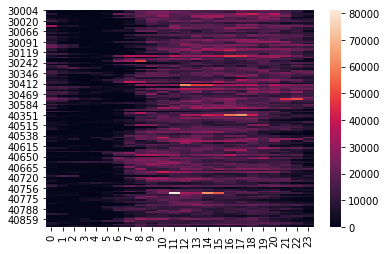

In [22]:
sns.heatmap(actdf.T)